In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [2]:
not_to_be_selected_list=[
       'Activity Summary', 'Viability Activity', 'PUBCHEM_ACTIVITY_SCORE',
       'Viability Potency (uM)', 'Viability Efficacy (%)', "index",
                         "Nuclei_Correlation_Manders_AGP_DNA",
            "Nuclei_Correlation_Manders_AGP_ER",
            "Nuclei_Correlation_Manders_AGP_Mito",
            "Nuclei_Correlation_Manders_AGP_RNA",
            "Nuclei_Correlation_Manders_DNA_AGP",
            "Nuclei_Correlation_Manders_DNA_ER",
            "Nuclei_Correlation_Manders_DNA_Mito",
            "Nuclei_Correlation_Manders_DNA_RNA",
            "Nuclei_Correlation_Manders_ER_AGP",
            "Nuclei_Correlation_Manders_ER_DNA",
            "Nuclei_Correlation_Manders_ER_Mito",
            "Nuclei_Correlation_Manders_ER_RNA",
            "Nuclei_Correlation_Manders_Mito_AGP",
            "Nuclei_Correlation_Manders_Mito_DNA",
            "Nuclei_Correlation_Manders_Mito_ER",
            "Nuclei_Correlation_Manders_Mito_RNA",
            "Nuclei_Correlation_Manders_RNA_AGP",
            "Nuclei_Correlation_Manders_RNA_DNA",
            "Nuclei_Correlation_Manders_RNA_ER",
            "Nuclei_Correlation_Manders_RNA_Mito",
            "Nuclei_Correlation_RWC_AGP_DNA",
            "Nuclei_Correlation_RWC_AGP_ER",
            "Nuclei_Correlation_RWC_AGP_Mito",
            "Nuclei_Correlation_RWC_AGP_RNA",
            "Nuclei_Correlation_RWC_DNA_AGP",
            "Nuclei_Correlation_RWC_DNA_ER",
            "Nuclei_Correlation_RWC_DNA_Mito",
            "Nuclei_Correlation_RWC_DNA_RNA",
            "Nuclei_Correlation_RWC_ER_AGP",
            "Nuclei_Correlation_RWC_ER_DNA",
            "Nuclei_Correlation_RWC_ER_Mito",
            "Nuclei_Correlation_RWC_ER_RNA",
            "Nuclei_Correlation_RWC_Mito_AGP",
            "Nuclei_Correlation_RWC_Mito_DNA",
            "Nuclei_Correlation_RWC_Mito_ER",
            "Nuclei_Correlation_RWC_Mito_RNA",
            "Nuclei_Correlation_RWC_RNA_AGP",
            "Nuclei_Correlation_RWC_RNA_DNA",
            "Nuclei_Correlation_RWC_RNA_ER",
            "Nuclei_Correlation_RWC_RNA_Mito",
            "Nuclei_Granularity_14_AGP",
            "Nuclei_Granularity_14_DNA",
            "Nuclei_Granularity_14_ER",
            "Nuclei_Granularity_14_Mito",
            "Nuclei_Granularity_14_RNA",
            "Nuclei_Granularity_15_AGP",
            "Nuclei_Granularity_15_DNA",
            "Nuclei_Granularity_15_ER",
            "Nuclei_Granularity_15_Mito",
            "Nuclei_Granularity_15_RNA",
            "Nuclei_Granularity_16_AGP",
            "Nuclei_Granularity_16_DNA",
            "Nuclei_Granularity_16_ER",
            "Nuclei_Granularity_16_Mito",
            "Nuclei_Granularity_16_RNA"]

In [3]:
df =pd.read_csv("../CP_MitoOverlap_nocelldeath_486.csv" ,  usecols=lambda x: x not in not_to_be_selected_list)
df

,StdInChI,PUBCHEM_ACTIVITY_OUTCOME,Metadata_mmoles_per_liter,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,InChI=1S/C10H10N2O/c1-8-7-10(13)12(11-8)9-5-3-...,1,14.351386,83.085938,6.679688,-2.980469,-0.003898,0.002892,0.0,-0.001432,...,-0.284535,-0.059237,-0.073432,-0.070867,-0.037841,-0.081784,-0.085790,-0.083668,-0.064161,-0.074736
1,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",0,5.000000,-322.046875,2.464844,0.167969,-0.015848,-0.005454,0.0,-0.000505,...,-0.180413,-0.048030,-0.110928,-0.107340,0.018558,0.028730,0.039671,-0.085405,-0.065859,-0.072910
2,"InChI=1S/C10H11ClO3/c1-10(2,9(12)13)14-8-5-3-7...",0,5.000000,248.234375,-0.906250,2.101562,0.020288,0.015127,0.0,-0.003586,...,0.018151,-0.069855,-0.072328,-0.057087,-0.138879,-0.147273,-0.149924,0.068768,0.024385,0.045882
3,InChI=1S/C10H11N3O3S/c1-7-6-10(12-16-7)13-17(1...,0,5.000000,52.718750,2.210938,-7.246094,0.012083,0.009969,0.0,0.002822,...,-0.119692,-0.048863,-0.094032,-0.103044,-0.018229,-0.010288,-0.001337,-0.068882,-0.045866,-0.060599
4,InChI=1S/C10H11NO3/c12-9(13)6-7-11-10(14)8-4-2...,0,5.000000,-82.320312,12.632812,-2.867188,0.008052,0.007536,0.0,-0.003234,...,0.054835,0.069209,-0.003243,0.010683,-0.096550,-0.070548,-0.097766,-0.043277,-0.061930,-0.064289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,InChI=1S/C9H5I2NO/c10-6-4-7(11)9(13)8-5(6)2-1-...,0,5.000000,183.582031,8.214844,-1.503906,0.028557,0.016230,0.0,-0.004420,...,-0.106812,-0.107515,-0.131245,-0.137058,-0.034026,-0.026922,-0.042310,-0.026980,-0.031024,-0.034233
482,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...,0,5.000000,94.007812,2.308594,2.988281,0.004868,0.006898,0.0,-0.002506,...,-0.023132,-0.104778,-0.084371,-0.075211,-0.033169,-0.004445,0.005263,-0.036537,-0.017949,-0.027655
483,"InChI=1S/C9H9N3O2S2/c10-7-1-3-8(4-2-7)16(13,14...",0,5.000000,185.621094,6.777344,-7.761719,0.020688,0.007500,0.0,-0.009577,...,-0.023423,0.017906,-0.026654,-0.007774,-0.088286,-0.052080,-0.073599,-0.055808,-0.070133,-0.061253
484,InChI=1S/C9H9N3S/c10-12-9-11-8(6-13-9)7-4-2-1-...,1,5.000000,145.597656,12.527344,-2.925781,-0.002326,-0.005159,0.0,0.001329,...,-0.195138,0.016896,-0.051576,-0.037506,0.024493,-0.068306,-0.061661,-0.000086,-0.012303,-0.012416


In [4]:
from rdkit.Chem import inchi
from rdkit import Chem

def get_standardize_smiles(value):
    try: return Chem.MolToSmiles(Chem.inchi.MolFromInchi(value))
    except: return "Cannot_do"

In [5]:
from pandarallel import pandarallel
pandarallel.initialize()

df['smiles_r']=df['StdInChI'].parallel_apply(get_standardize_smiles)  
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,StdInChI,PUBCHEM_ACTIVITY_OUTCOME,Metadata_mmoles_per_liter,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,...,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,smiles_r
0,InChI=1S/C10H10N2O/c1-8-7-10(13)12(11-8)9-5-3-...,1,14.351386,83.085938,6.679688,-2.980469,-0.003898,0.002892,0.0,-0.001432,...,-0.059237,-0.073432,-0.070867,-0.037841,-0.081784,-0.085790,-0.083668,-0.064161,-0.074736,CC1=NN(c2ccccc2)C(=O)C1
1,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",0,5.000000,-322.046875,2.464844,0.167969,-0.015848,-0.005454,0.0,-0.000505,...,-0.048030,-0.110928,-0.107340,0.018558,0.028730,0.039671,-0.085405,-0.065859,-0.072910,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1
2,"InChI=1S/C10H11ClO3/c1-10(2,9(12)13)14-8-5-3-7...",0,5.000000,248.234375,-0.906250,2.101562,0.020288,0.015127,0.0,-0.003586,...,-0.069855,-0.072328,-0.057087,-0.138879,-0.147273,-0.149924,0.068768,0.024385,0.045882,CC(C)(Oc1ccc(Cl)cc1)C(=O)O
3,InChI=1S/C10H11N3O3S/c1-7-6-10(12-16-7)13-17(1...,0,5.000000,52.718750,2.210938,-7.246094,0.012083,0.009969,0.0,0.002822,...,-0.048863,-0.094032,-0.103044,-0.018229,-0.010288,-0.001337,-0.068882,-0.045866,-0.060599,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1
4,InChI=1S/C10H11NO3/c12-9(13)6-7-11-10(14)8-4-2...,0,5.000000,-82.320312,12.632812,-2.867188,0.008052,0.007536,0.0,-0.003234,...,0.069209,-0.003243,0.010683,-0.096550,-0.070548,-0.097766,-0.043277,-0.061930,-0.064289,O=C(O)CCN=C(O)c1ccccc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,InChI=1S/C9H5I2NO/c10-6-4-7(11)9(13)8-5(6)2-1-...,0,5.000000,183.582031,8.214844,-1.503906,0.028557,0.016230,0.0,-0.004420,...,-0.107515,-0.131245,-0.137058,-0.034026,-0.026922,-0.042310,-0.026980,-0.031024,-0.034233,Oc1c(I)cc(I)c2cccnc12
482,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...,0,5.000000,94.007812,2.308594,2.988281,0.004868,0.006898,0.0,-0.002506,...,-0.104778,-0.084371,-0.075211,-0.033169,-0.004445,0.005263,-0.036537,-0.017949,-0.027655,O=c1ccc2ccccc2o1
483,"InChI=1S/C9H9N3O2S2/c10-7-1-3-8(4-2-7)16(13,14...",0,5.000000,185.621094,6.777344,-7.761719,0.020688,0.007500,0.0,-0.009577,...,0.017906,-0.026654,-0.007774,-0.088286,-0.052080,-0.073599,-0.055808,-0.070133,-0.061253,Nc1ccc(S(=O)(=O)Nc2nccs2)cc1
484,InChI=1S/C9H9N3S/c10-12-9-11-8(6-13-9)7-4-2-1-...,1,5.000000,145.597656,12.527344,-2.925781,-0.002326,-0.005159,0.0,0.001329,...,0.016896,-0.051576,-0.037506,0.024493,-0.068306,-0.061661,-0.000086,-0.012303,-0.012416,NNc1nc(-c2ccccc2)cs1


In [6]:
len(df[df["PUBCHEM_ACTIVITY_OUTCOME"]==1]["StdInChI"].unique())

85

In [7]:
#Morgan Fingerprint Correlations
#Active vs Active

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

# proof and make a list of SMILES
df_smiles = df[df.PUBCHEM_ACTIVITY_OUTCOME==1]['smiles_r']
c_smiles = []
for ds in df_smiles:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)
print()

# make a list of mols
ms = [Chem.MolFromSmiles(x) for x in c_smiles]

# make a list of fingerprints (fp)
fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in ms]
print(len(fps))

# the list for the dataframe
qu, ta, sim = [], [], []

# compare all fp pairwise without duplicates
for n in range(len(fps)): # -1 so the last fp will not be used
    s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[:]) # +1 compare with the next to the last fp
    #print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
    # collect the SMILES and values
    for m in range(len(s)):
        qu.append(c_smiles[n])
        ta.append(c_smiles[:][m])
        sim.append(s[m])


# build the dataframe and sort it
d = {'query':qu, 'target':ta, 'MFP_Tc':sim}
df_final_aa = pd.DataFrame(data=d)
df_final_aa = df_final_aa.sort_values('MFP_Tc', ascending=False)
df_final_aa=df_final_aa.reset_index()
df_final_aa

# save as csv
#df_final.to_csv('third.csv', index=False, sep=',')


85


,index,query,target,MFP_Tc
0,0,CC1=NN(c2ccccc2)C(=O)C1,CC1=NN(c2ccccc2)C(=O)C1,1.0
1,1892,O=C1c2ccccc2C(=O)c2c1ccc(O)c2O,O=C1c2ccccc2C(=O)c2c1ccc(O)c2O,1.0
2,2064,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,1.0
3,2150,Cc1cc(O)c2c(c1)C(=O)c1cccc(O)c1C2=O,Cc1cc(O)c2c(c1)C(=O)c1cccc(O)c1C2=O,1.0
4,2236,O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12,O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12,1.0
...,...,...,...,...
7220,184,CCN(CC)C(=S)SSC(=S)N(CC)CC,O=c1c2ccccc2[se]n1-c1ccccc1,0.0
7221,1787,O=C1c2ccccc2C(=O)c2ccccc21,CCN(CC)C(=S)SSC(=S)N(CC)CC,0.0
7222,194,CCN(CC)C(=S)SSC(=S)N(CC)CC,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,0.0
7223,191,CCN(CC)C(=S)SSC(=S)N(CC)CC,O=C1c2ccccc2C(=O)c2ccccc21,0.0


In [8]:
df_final_aa = df_final_aa[df_final_aa["query"] != df_final_aa["target"]]
df_final_aa

,index,query,target,MFP_Tc
85,2579,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,0.783784
86,2495,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,0.783784
87,4385,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,0.765957
88,4301,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,0.765957
89,5502,O=C(CCCN1CCC2(CC1)C(O)=NCN2c1ccccc1)c1ccc(F)cc1,OC1=NCN(c2ccccc2)C12CCN(CCCOc1ccc(F)cc1)CC2,0.689655
...,...,...,...,...
7220,184,CCN(CC)C(=S)SSC(=S)N(CC)CC,O=c1c2ccccc2[se]n1-c1ccccc1,0.000000
7221,1787,O=C1c2ccccc2C(=O)c2ccccc21,CCN(CC)C(=S)SSC(=S)N(CC)CC,0.000000
7222,194,CCN(CC)C(=S)SSC(=S)N(CC)CC,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,0.000000
7223,191,CCN(CC)C(=S)SSC(=S)N(CC)CC,O=C1c2ccccc2C(=O)c2ccccc21,0.000000


In [9]:
len(df_final_aa["query"].unique())

85

In [10]:
#Morgan Fingerprint Correlations
#Active vs Inactive

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

# proof and make a list of SMILES

df_smiles_a = df[df.PUBCHEM_ACTIVITY_OUTCOME==1]['smiles_r']
df_smiles_i = df[df.PUBCHEM_ACTIVITY_OUTCOME==0]['smiles_r'].sample(n = 85, random_state=42) #Same size dataframe


c_smiles_a = []
for ds in df_smiles_a:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles_a.append(cs)
    except:
        print('Invalid SMILES:', ds)
print()


c_smiles_i = []
for ds in df_smiles_i:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles_i.append(cs)
    except:
        print('Invalid SMILES:', ds)
print()



# make a list of mols
ms_a = [Chem.MolFromSmiles(x) for x in c_smiles_a]

# make a list of fingerprints (fp)
fps_a = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in ms_a]

# make a list of mols
ms_i = [Chem.MolFromSmiles(x) for x in c_smiles_i]

# make a list of fingerprints (fp)
fps_i = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in ms_i]



# the list for the dataframe
qu, ta, sim = [], [], []

for a in range(len(fps_a)):
    
    s = DataStructs.BulkTanimotoSimilarity(fps_a[a], fps_i)    
    for m in range(len(s)):
        qu.append(c_smiles_a[a])
        ta.append(c_smiles_i[m])
        sim.append(s[m])

# build the dataframe and sort it
d = {'query':qu, 'target':ta, 'MFP_Tc':sim}
df_final_ai= pd.DataFrame(data=d)
df_final_ai = df_final_ai.sort_values('MFP_Tc', ascending=False)
df_final_ai=df_final_ai.reset_index()
df_final_ai

# save as csv
#df_final.to_csv('third.csv', index=False, sep=',')

,index,query,target,MFP_Tc
0,2674,N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O,N[C@@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(...,0.744186
1,1739,O=C(O)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1,N[C@@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(...,0.634146
2,5510,O=C(CCCN1CCC2(CC1)C(O)=NCN2c1ccccc1)c1ccc(F)cc1,O=C(CCCN1CCC(n2c(O)nc3ccccc32)CC1)c1ccc(F)cc1,0.470588
3,4865,COc1cc(/C=C/C(=O)CC(=O)/C=C/c2ccc(O)c(OC)c2)ccc1O,CCN(CC)C(=O)c1ccc(O)c(OC)c1,0.441860
4,1140,CC(C)Cc1ccc(C(C)C(=O)O)cc1,COc1ccc2cc([C@H](C)C(=O)O)ccc2c1,0.421053
...,...,...,...,...
7220,1825,O=C1c2ccccc2C(=O)c2ccccc21,OCCNCCO,0.000000
7221,544,c1ccc2c(c1)OCC(C1=NCCN1)O2,CC(C)CC(O)=N[C@H](C(O)=N[C@H](C(O)=N[C@@H](CC(...,0.000000
7222,7117,NNc1nc(-c2ccccc2)cs1,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4C[C@H](O)CC...,0.000000
7223,2080,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,OCCNCCO,0.000000


In [11]:
len(df_final_ai["query"].unique())

85

In [12]:
len(df_final_aa["query"].unique())

85

In [13]:
#df_final_aa = df_final_aa.drop("index", axis=1)
df_final_aa["Category"] = "Active vs Active"


#df_final_ai = df_final_ai.drop("index", axis=1)
df_final_ai["Category"] = "Active vs Inactive"


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [14]:
frames=[df_final_aa, df_final_ai]
df_plot=pd.concat(frames)
df_plot

,index,query,target,MFP_Tc,Category
85,2579,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,0.783784,Active vs Active
86,2495,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,0.783784,Active vs Active
87,4385,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,0.765957,Active vs Active
88,4301,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,0.765957,Active vs Active
89,5502,O=C(CCCN1CCC2(CC1)C(O)=NCN2c1ccccc1)c1ccc(F)cc1,OC1=NCN(c2ccccc2)C12CCN(CCCOc1ccc(F)cc1)CC2,0.689655,Active vs Active
...,...,...,...,...,...
7220,1825,O=C1c2ccccc2C(=O)c2ccccc21,OCCNCCO,0.000000,Active vs Inactive
7221,544,c1ccc2c(c1)OCC(C1=NCCN1)O2,CC(C)CC(O)=N[C@H](C(O)=N[C@H](C(O)=N[C@@H](CC(...,0.000000,Active vs Inactive
7222,7117,NNc1nc(-c2ccccc2)cs1,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4C[C@H](O)CC...,0.000000,Active vs Inactive
7223,2080,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,OCCNCCO,0.000000,Active vs Inactive


In [15]:
import ptitprince as pt

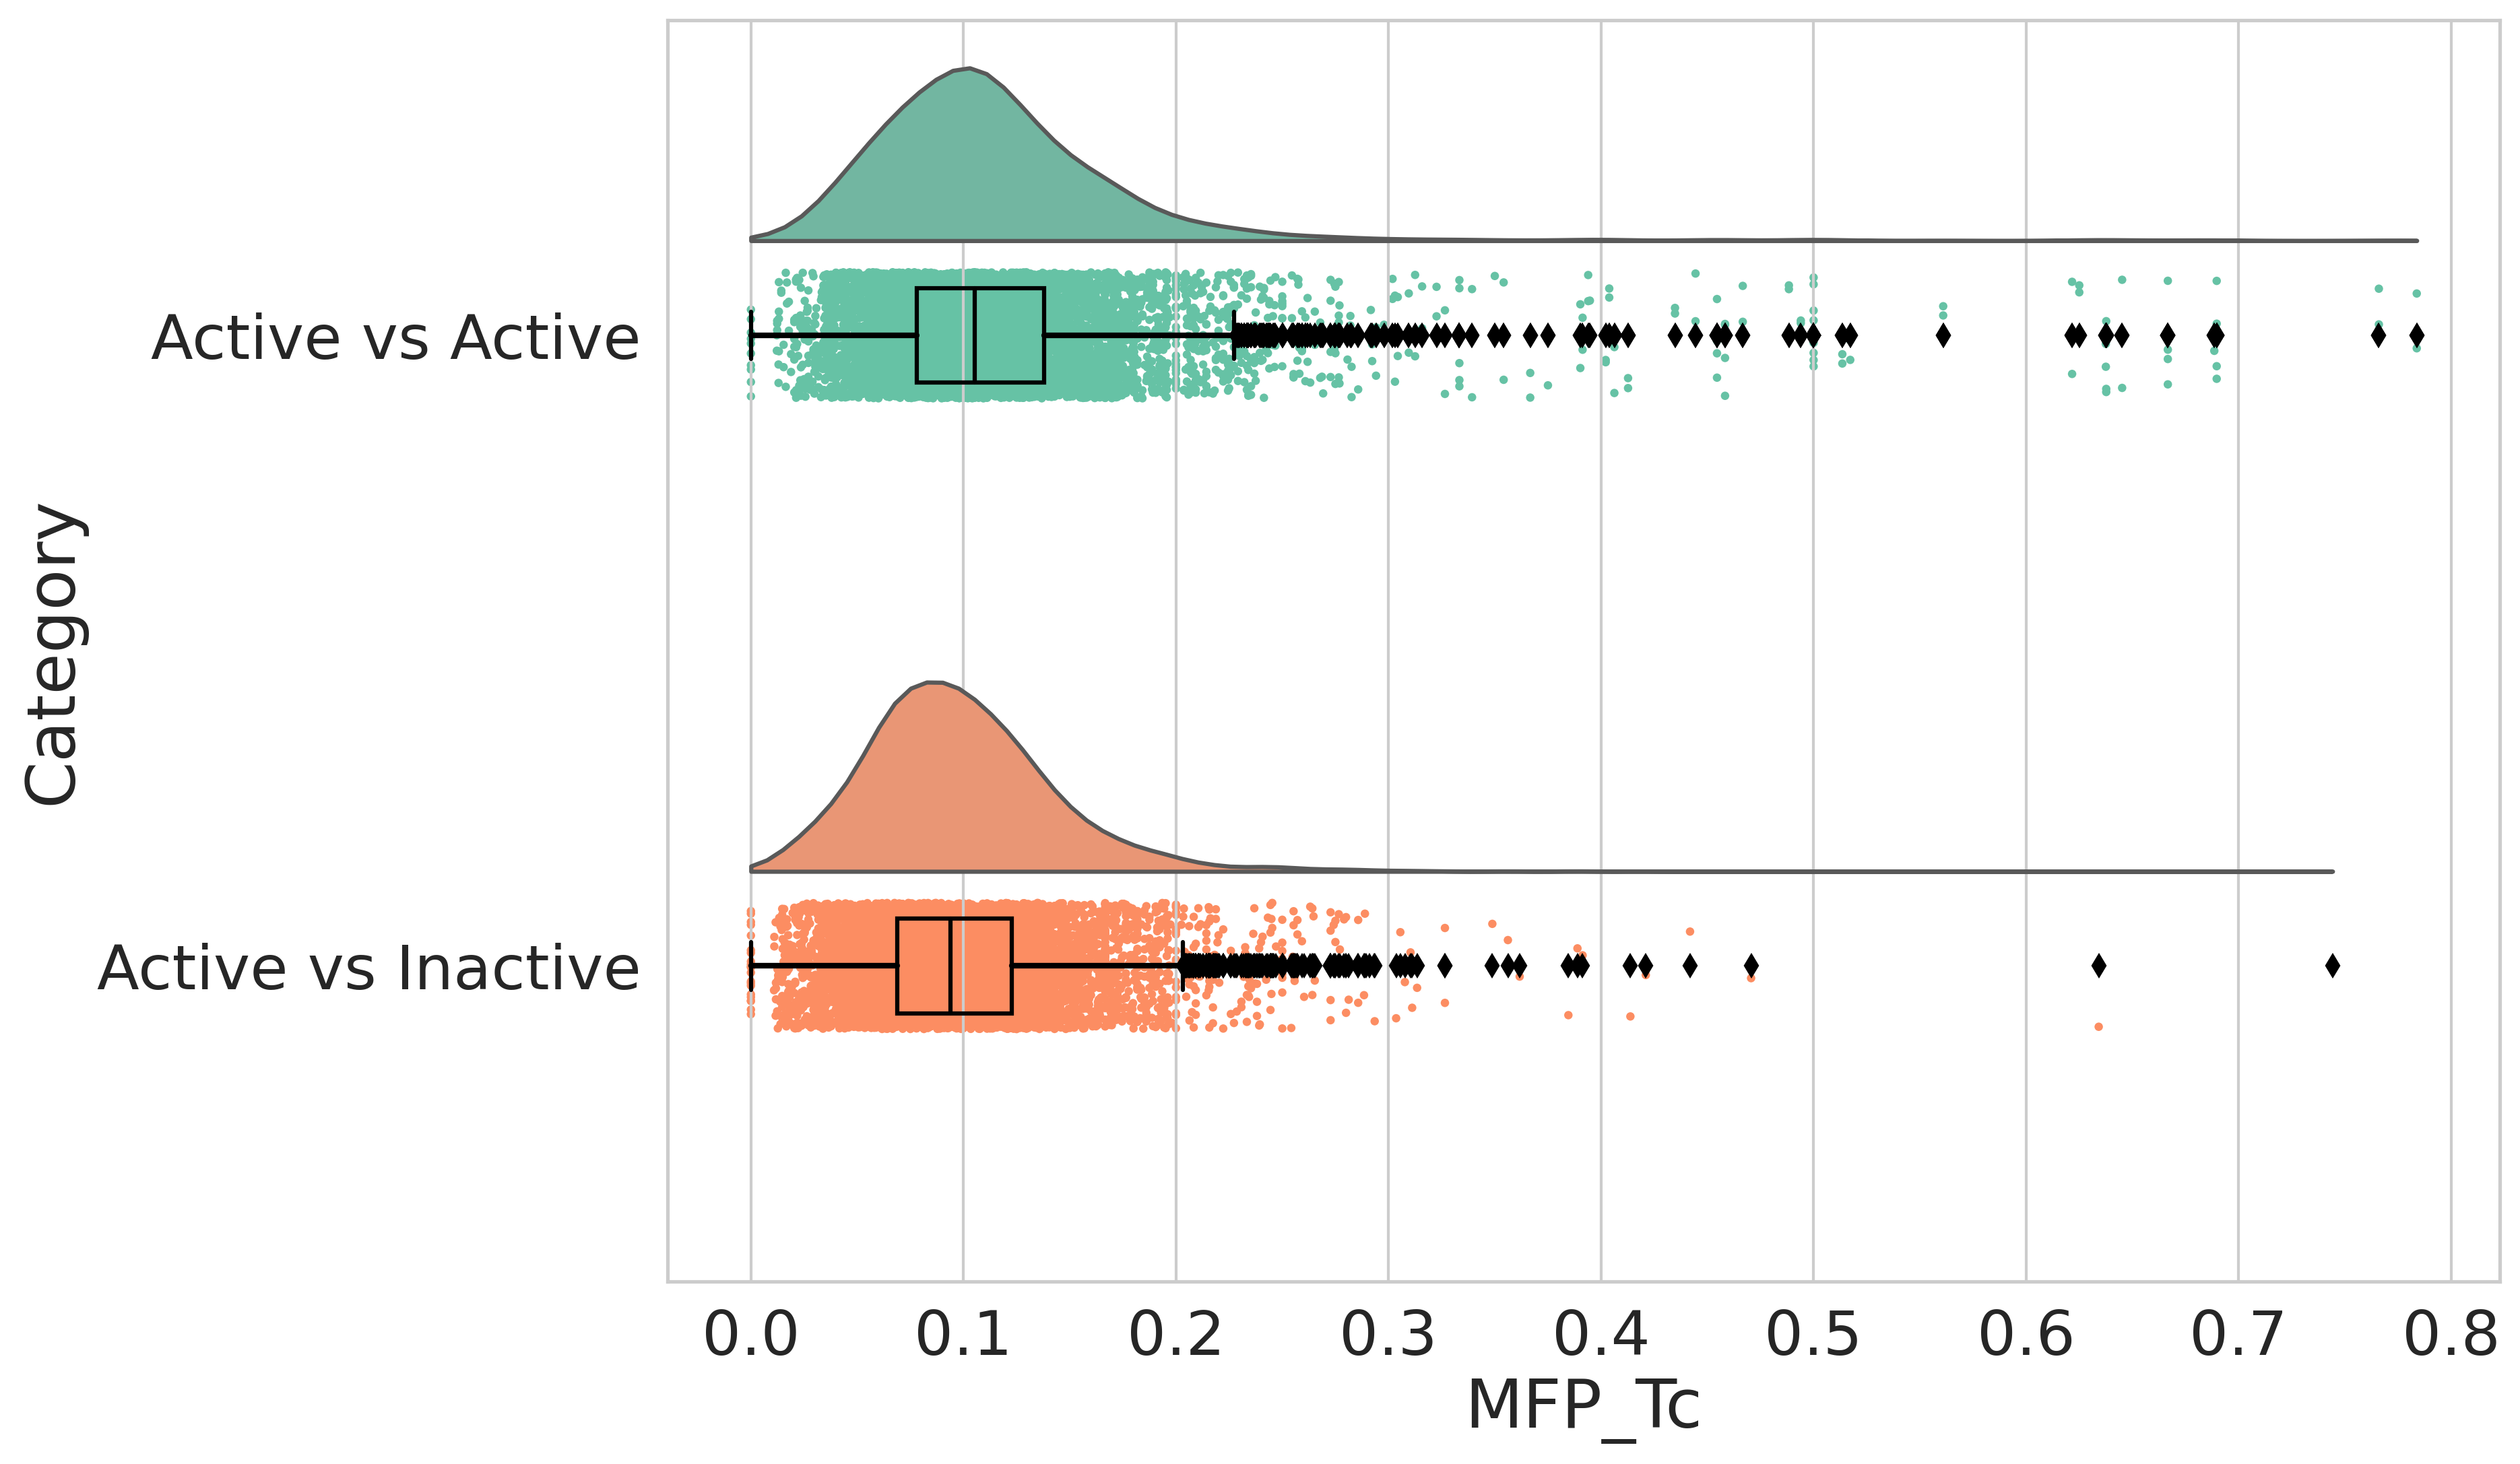

In [16]:
pal = "Set2"

sns.set(rc={'figure.figsize':(11.7,8.27), "figure.dpi":300}, font_scale=2)
sns.set_style("whitegrid")

ax=pt.half_violinplot( x = 'MFP_Tc', y = 'Category', data = df_plot, palette = pal,
     bw = .2, cut = 0.,scale = "area", width = .6, 
     inner = None, orient = 'h')
df_plot
ax=sns.stripplot( x = 'MFP_Tc', y = 'Category', data = df_plot, palette = pal,
      edgecolor = "white",size = 3, jitter = 1, zorder = 0,
      orient = 'h')

ax=sns.boxplot( x = 'MFP_Tc', y = 'Category', data = df_plot, color = "black",
      width = .15, zorder = 10, showcaps = True,
      boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":10}, 
      saturation = 1, orient = 'h')

In [17]:
df_final_aa["MFP_Tc"].median()

0.10526315789473684

In [18]:
df_final_ai["MFP_Tc"].median()

0.09375

In [19]:
toxic_compounds = list(df_final_aa["query"].unique())
df_final_aa

,index,query,target,MFP_Tc,Category
85,2579,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,0.783784,Active vs Active
86,2495,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,0.783784,Active vs Active
87,4385,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,0.765957,Active vs Active
88,4301,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,0.765957,Active vs Active
89,5502,O=C(CCCN1CCC2(CC1)C(O)=NCN2c1ccccc1)c1ccc(F)cc1,OC1=NCN(c2ccccc2)C12CCN(CCCOc1ccc(F)cc1)CC2,0.689655,Active vs Active
...,...,...,...,...,...
7220,184,CCN(CC)C(=S)SSC(=S)N(CC)CC,O=c1c2ccccc2[se]n1-c1ccccc1,0.000000,Active vs Active
7221,1787,O=C1c2ccccc2C(=O)c2ccccc21,CCN(CC)C(=S)SSC(=S)N(CC)CC,0.000000,Active vs Active
7222,194,CCN(CC)C(=S)SSC(=S)N(CC)CC,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,0.000000,Active vs Active
7223,191,CCN(CC)C(=S)SSC(=S)N(CC)CC,O=C1c2ccccc2C(=O)c2ccccc21,0.000000,Active vs Active


In [20]:
len(df_final_aa["query"].unique())

85

In [21]:
len(df_final_ai["query"].unique())

85

In [22]:
df_final_ai[df_final_ai["query"]=="CC(C)Cc1ccc(C(C)C(=O)O)cc1"].sort_values("MFP_Tc")

,index,query,target,MFP_Tc,Category
6894,1179,CC(C)Cc1ccc(C(C)C(=O)O)cc1,COc1nc(C)nc(Cl)c1NC1=NCCN1,0.033898,Active vs Inactive
6832,1153,CC(C)Cc1ccc(C(C)C(=O)O)cc1,C=CCN1CCc2[nH]c(=N)sc2CC1,0.036364,Active vs Inactive
6104,1107,CC(C)Cc1ccc(C(C)C(=O)O)cc1,c1ccc2[nH]c(-c3cscn3)nc2c1,0.057692,Active vs Inactive
6107,1182,CC(C)Cc1ccc(C(C)C(=O)O)cc1,N=c1[nH]c2ccc(OC(F)(F)F)cc2s1,0.057692,Active vs Inactive
6070,1135,CC(C)Cc1ccc(C(C)C(=O)O)cc1,CN(C)c1nc(N(C)C)nc(N(C)C)n1,0.058824,Active vs Inactive
...,...,...,...,...,...
123,1174,CC(C)Cc1ccc(C(C)C(=O)O)cc1,CS(=O)(=O)c1ccc([C@@H](O)[C@@H](CO)N=C(O)C(Cl)...,0.215686,Active vs Inactive
71,1144,CC(C)Cc1ccc(C(C)C(=O)O)cc1,N[C@@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(...,0.244898,Active vs Inactive
51,1126,CC(C)Cc1ccc(C(C)C(=O)O)cc1,CCCCc1ccc(C(=O)O)nc1,0.255814,Active vs Inactive
7,1150,CC(C)Cc1ccc(C(C)C(=O)O)cc1,NC(Cc1ccc(Cl)cc1)C(=O)O,0.388889,Active vs Inactive


In [23]:
df_final_aa_2 = pd.DataFrame()
df_final_ai_2 = pd.DataFrame()

for compound in toxic_compounds:

    compounds_wise = pd.DataFrame()
    compounds_wise = df_final_aa[df_final_aa["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:5, :]
    df_final_aa_2 = pd.concat([df_final_aa_2, compounds_wise])

    compounds_wise = pd.DataFrame()
    compounds_wise = df_final_ai[df_final_ai["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:5, :]
    df_final_ai_2 = pd.concat([df_final_ai_2, compounds_wise])


df_final_aa_2 = df_final_aa_2.groupby('query').median().sort_values("MFP_Tc").reset_index()
df_final_ai_2 = df_final_ai_2.groupby('query').median().sort_values("MFP_Tc").reset_index()

In [24]:
df_final_aa_2["Category"] = "Toxic vs Toxic"
df_final_ai_2["Category"] = "Toxic vs Non-toxic"


frames=[df_final_aa_2, df_final_ai_2]
df_plot=pd.concat(frames)
df_plot

,query,index,MFP_Tc,Category
0,CCN(CC)C(=S)SSC(=S)N(CC)CC,209.0,0.102564,Toxic vs Toxic
1,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](N=C(...,6512.0,0.126214,Toxic vs Toxic
2,c1ccc2c(c1)OCC(C1=NCCN1)O2,559.0,0.134615,Toxic vs Toxic
3,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,5919.0,0.144578,Toxic vs Toxic
4,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@@]2(C)[C@H]1CC...,6089.0,0.144578,Toxic vs Toxic
...,...,...,...,...
80,CC(C)Cc1ccc(C(C)C(=O)O)cc1,1144.0,0.255814,Toxic vs Non-toxic
81,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,6356.0,0.255814,Toxic vs Non-toxic
82,O=C(CC(=O)c1ccccc1)c1ccccc1,2791.0,0.257143,Toxic vs Non-toxic
83,CC(O)=Nc1ccc(S(=O)(=O)Nc2ccc([N+](=O)[O-])cc2)cc1,1554.0,0.264151,Toxic vs Non-toxic


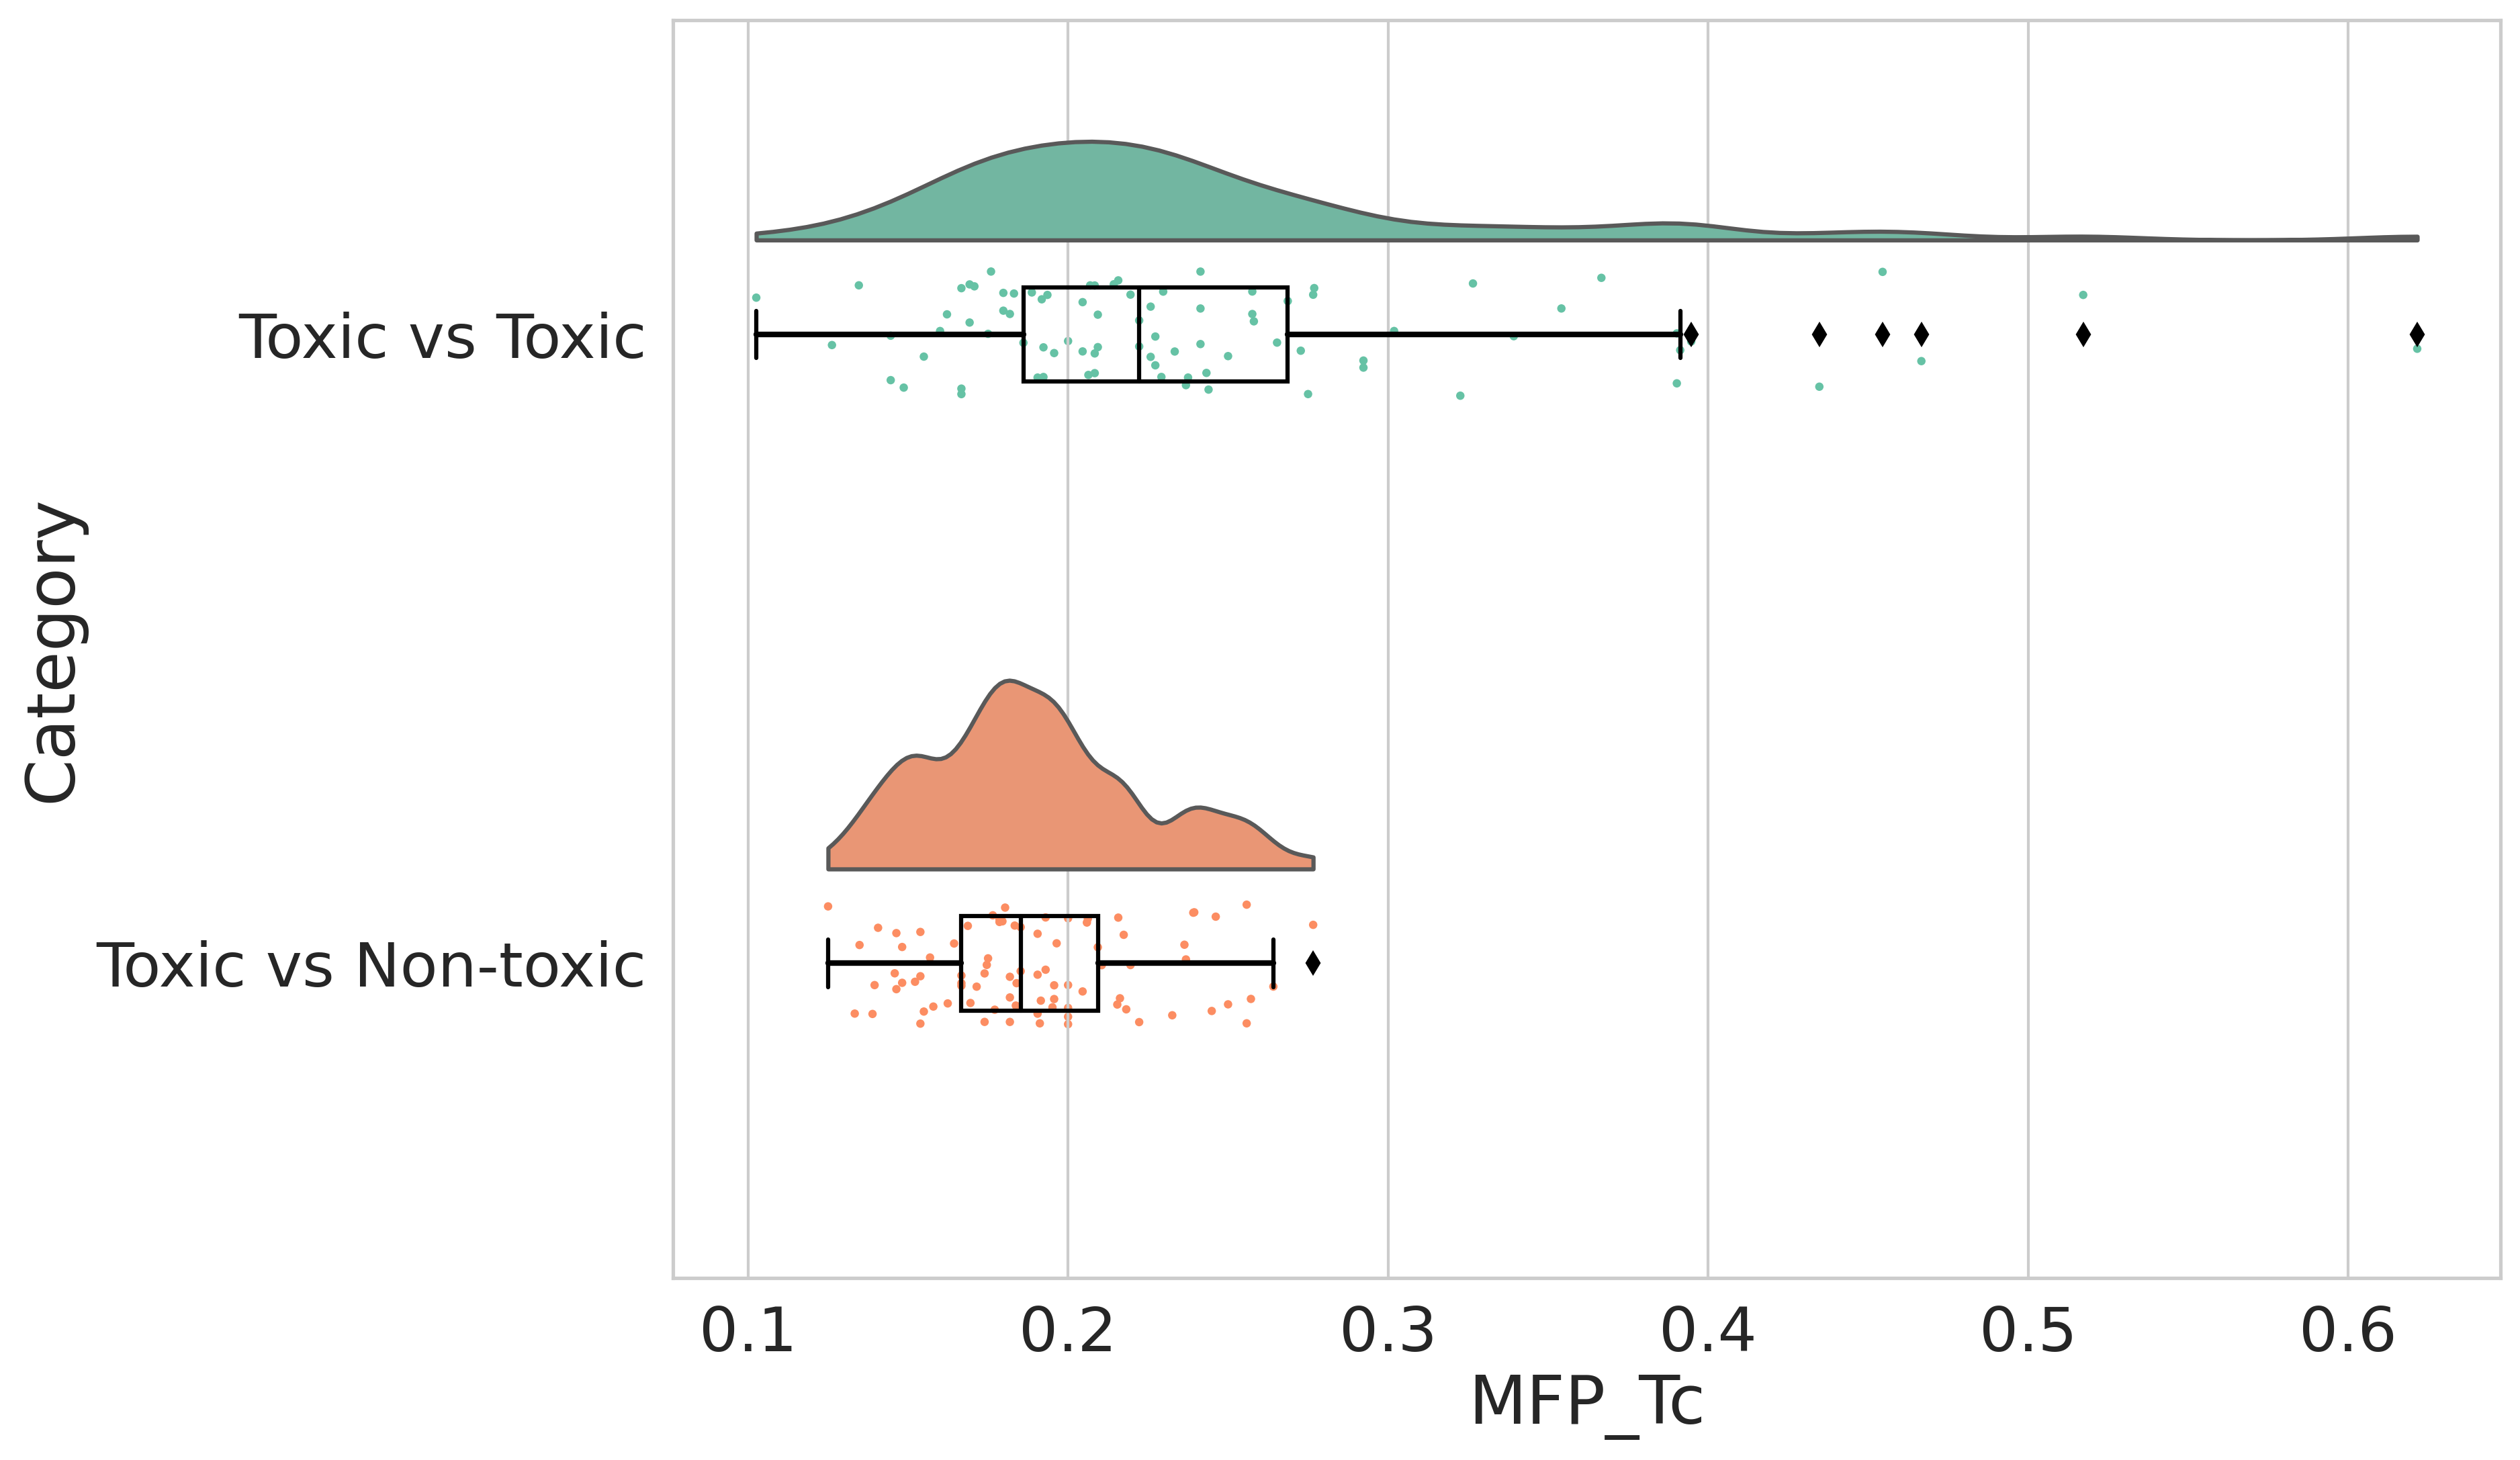

In [25]:
pal = "Set2"

sns.set(rc={'figure.figsize':(11.7,8.27), "figure.dpi":300}, font_scale=2)
sns.set_style("whitegrid")

ax=pt.half_violinplot( x = 'MFP_Tc', y = 'Category', data = df_plot, palette = pal,
     bw = .2, cut = 0.,scale = "area", width = .6, 
     inner = None, orient = 'h')
df_plot
ax=sns.stripplot( x = 'MFP_Tc', y = 'Category', data = df_plot, palette = pal,
      edgecolor = "white",size = 3, jitter = 1, zorder = 0,
      orient = 'h')

ax=sns.boxplot( x = 'MFP_Tc', y = 'Category', data = df_plot, color = "black",
      width = .15, zorder = 10, showcaps = True,
      boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":10}, 
      saturation = 1, orient = 'h')

In [26]:
df_final_aa_2["MFP_Tc"].median()

0.2222222222222222

In [27]:
df_final_ai_2["MFP_Tc"].median()

0.18518518518518517

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Toxic vs Toxic v.s. Toxic vs Non-toxic: t-test independent samples with Bonferroni correction, P_val=1.076e-06 stat=5.063e+00


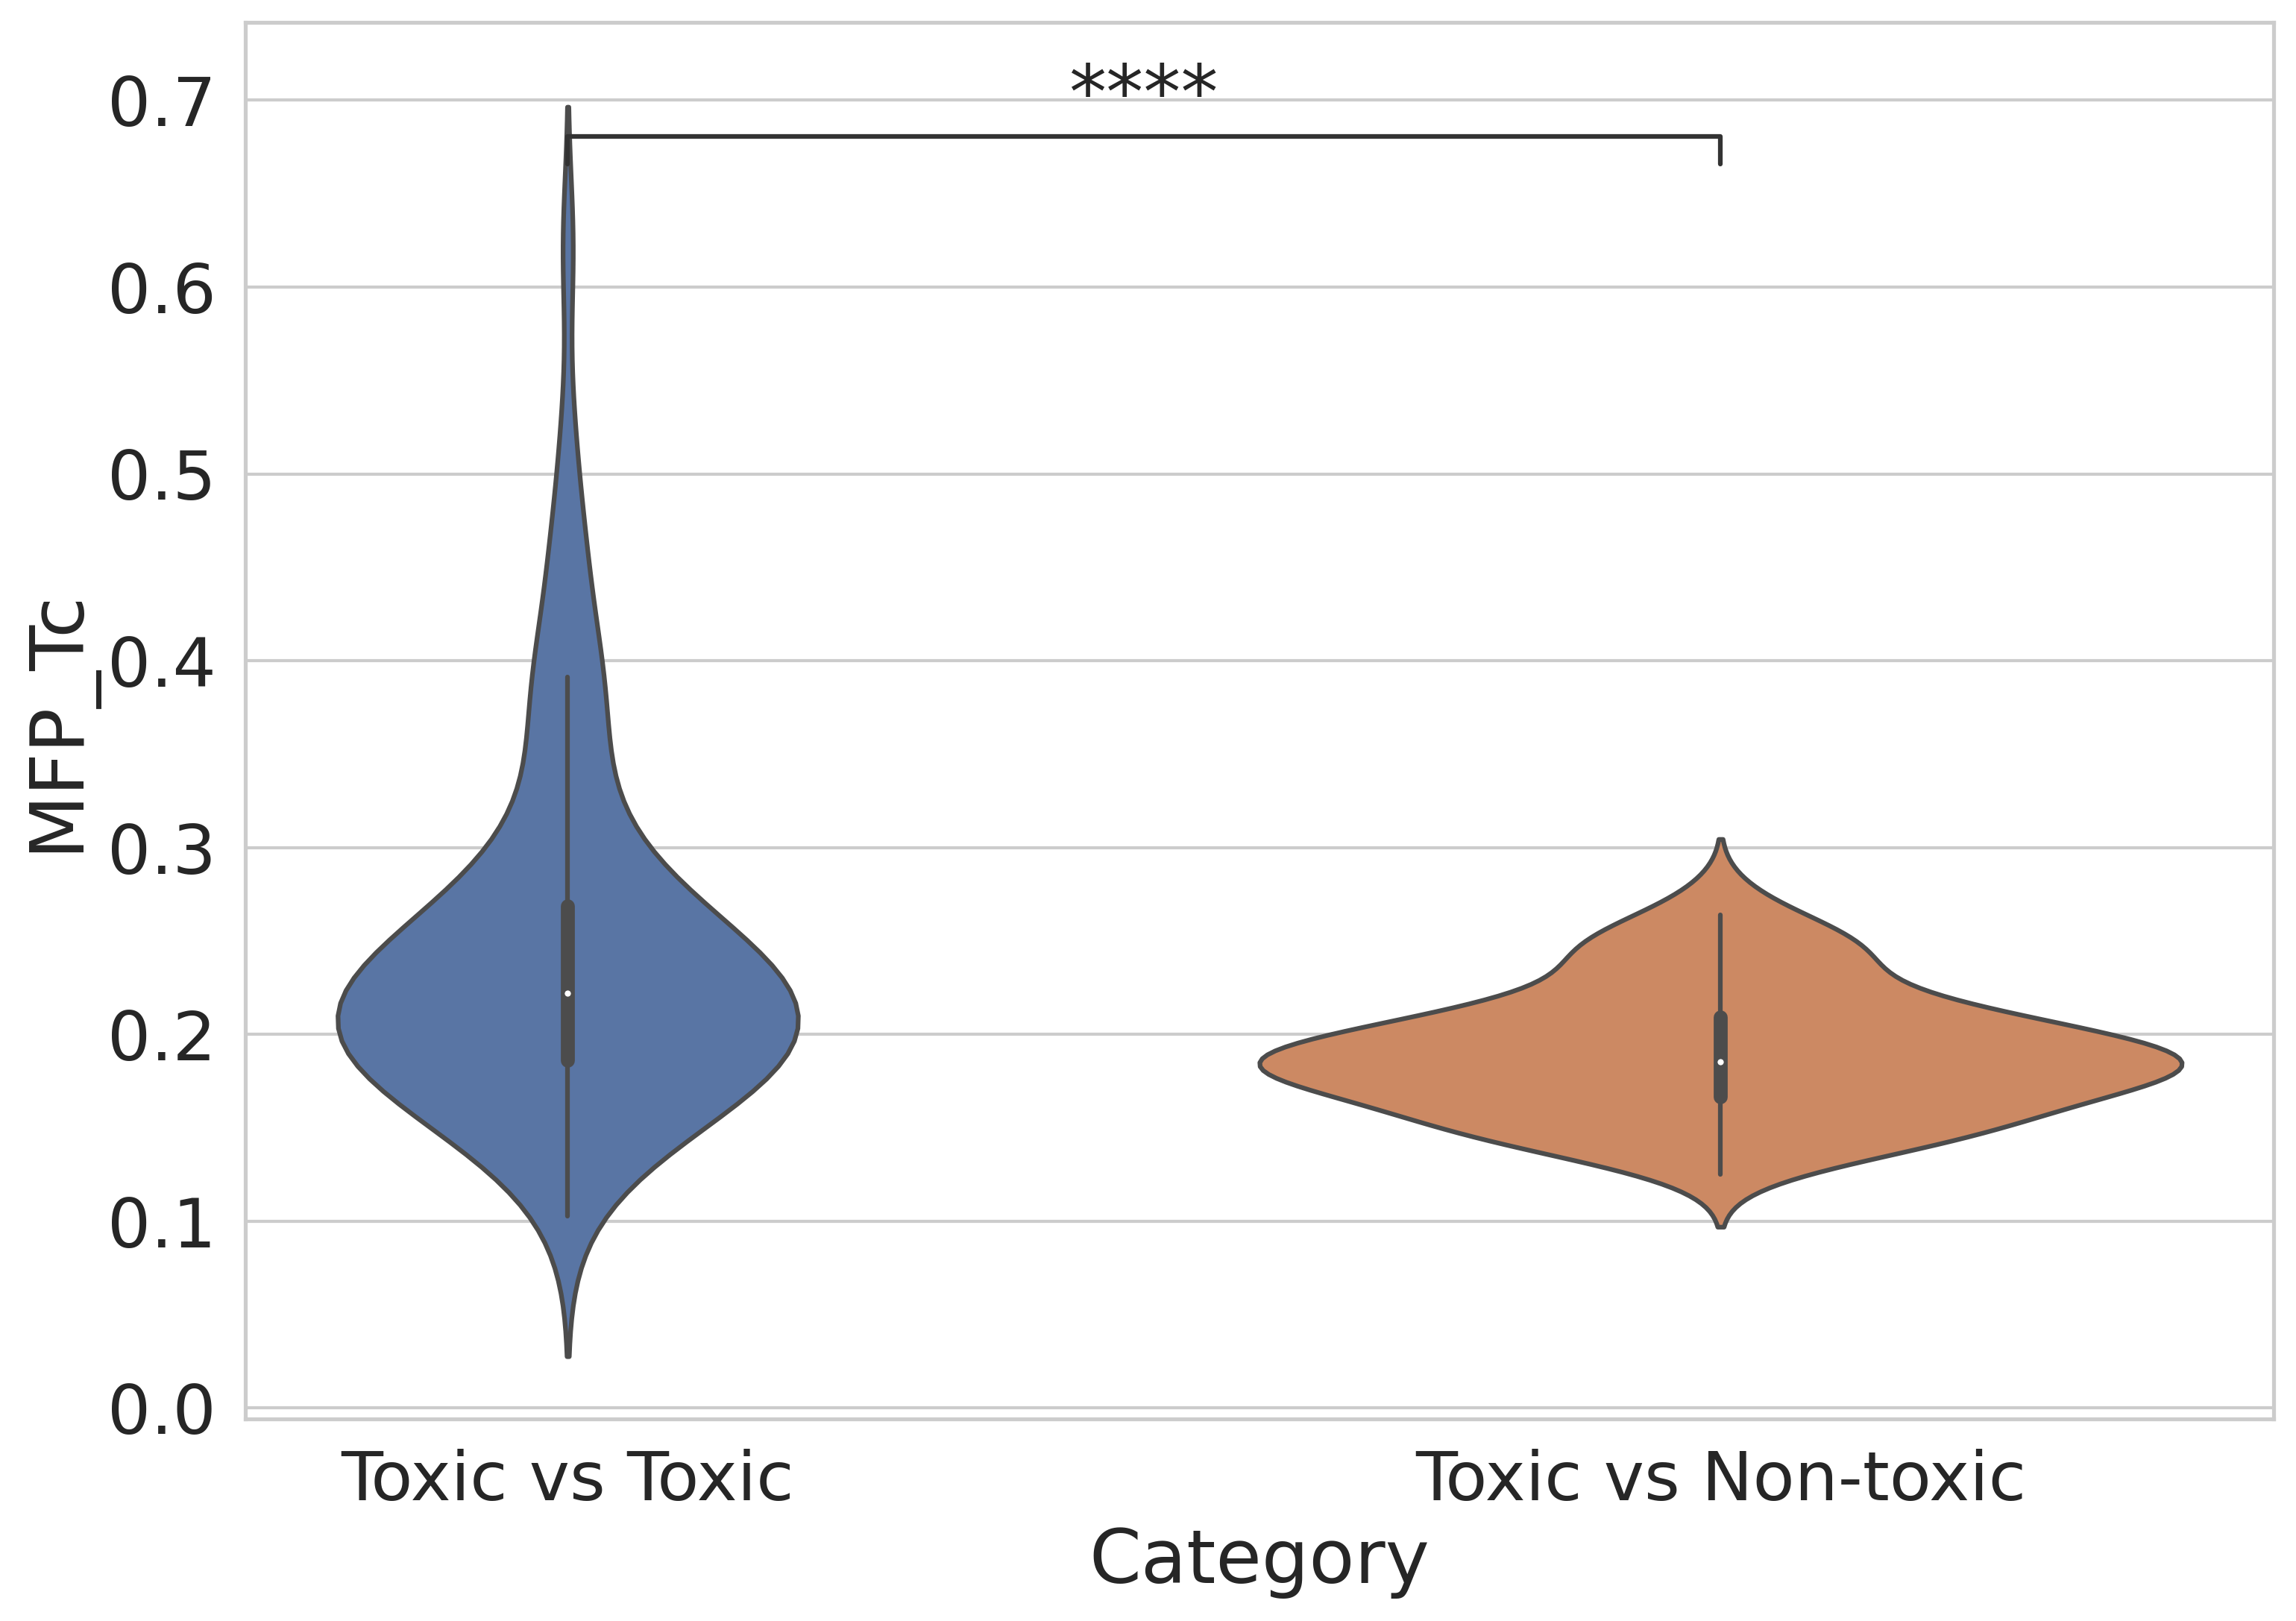

In [28]:
from statannot import add_stat_annotation
ax = sns.violinplot( x = 'Category', y = 'MFP_Tc', data = df_plot, order=["Toxic vs Toxic", "Toxic vs Non-toxic"])

ax, test_results = add_stat_annotation(ax, x = 'Category', y = 'MFP_Tc', data = df_plot, 
                                        order=["Toxic vs Toxic", "Toxic vs Non-toxic"],
                                       box_pairs=[("Toxic vs Toxic", "Toxic vs Non-toxic")], test='t-test_ind', verbose=2)
test_results
plt.show()

In [29]:
import numpy as np

df_final_aa_2 = pd.DataFrame()
df_final_ai_2 = pd.DataFrame()
    
def quantile_curves(D):

    quantiles = [0.25, 0.5, 0.75]
    print('quantiles:\n', quantiles)

    moments = [f'moment {i}' for i in range(1)]

    #D = np.array(df_plot[df_plot["Category"]=="Toxic vs Toxic"]["MFP_Tc"])

    quantile_values = np.quantile(D , quantiles , axis=0)
    print('quantile_values (for each moment):\n', quantile_values)

    quantile_curves = np.zeros((len(quantiles)+1))

    quantile_curves[0] = np.mean(np.ma.masked_array(D, mask=D>quantile_values[0]), axis=0)
    for q in range(len(quantiles)-1):
      quantile_curves[q+1] = np.mean(np.ma.masked_array(D, mask=np.logical_or(D<quantile_values[q], D>quantile_values[q+1])), axis=0)
    quantile_curves[len(quantiles)] = np.mean(np.ma.masked_array(D, mask=D<quantile_values[len(quantiles)-1]), axis=0)

    print('mean for each group and at each moment:')
    print(quantile_curves)
    return(quantile_curves)

1
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.25       0.31578947 0.56097561]
mean for each group and at each moment:
[0.21150487 0.27641362 0.44530551 0.6763333 ]
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.19811321 0.23404255 0.28125   ]
mean for each group and at each moment:
[0.17108748 0.21206214 0.25858843 0.36888637]


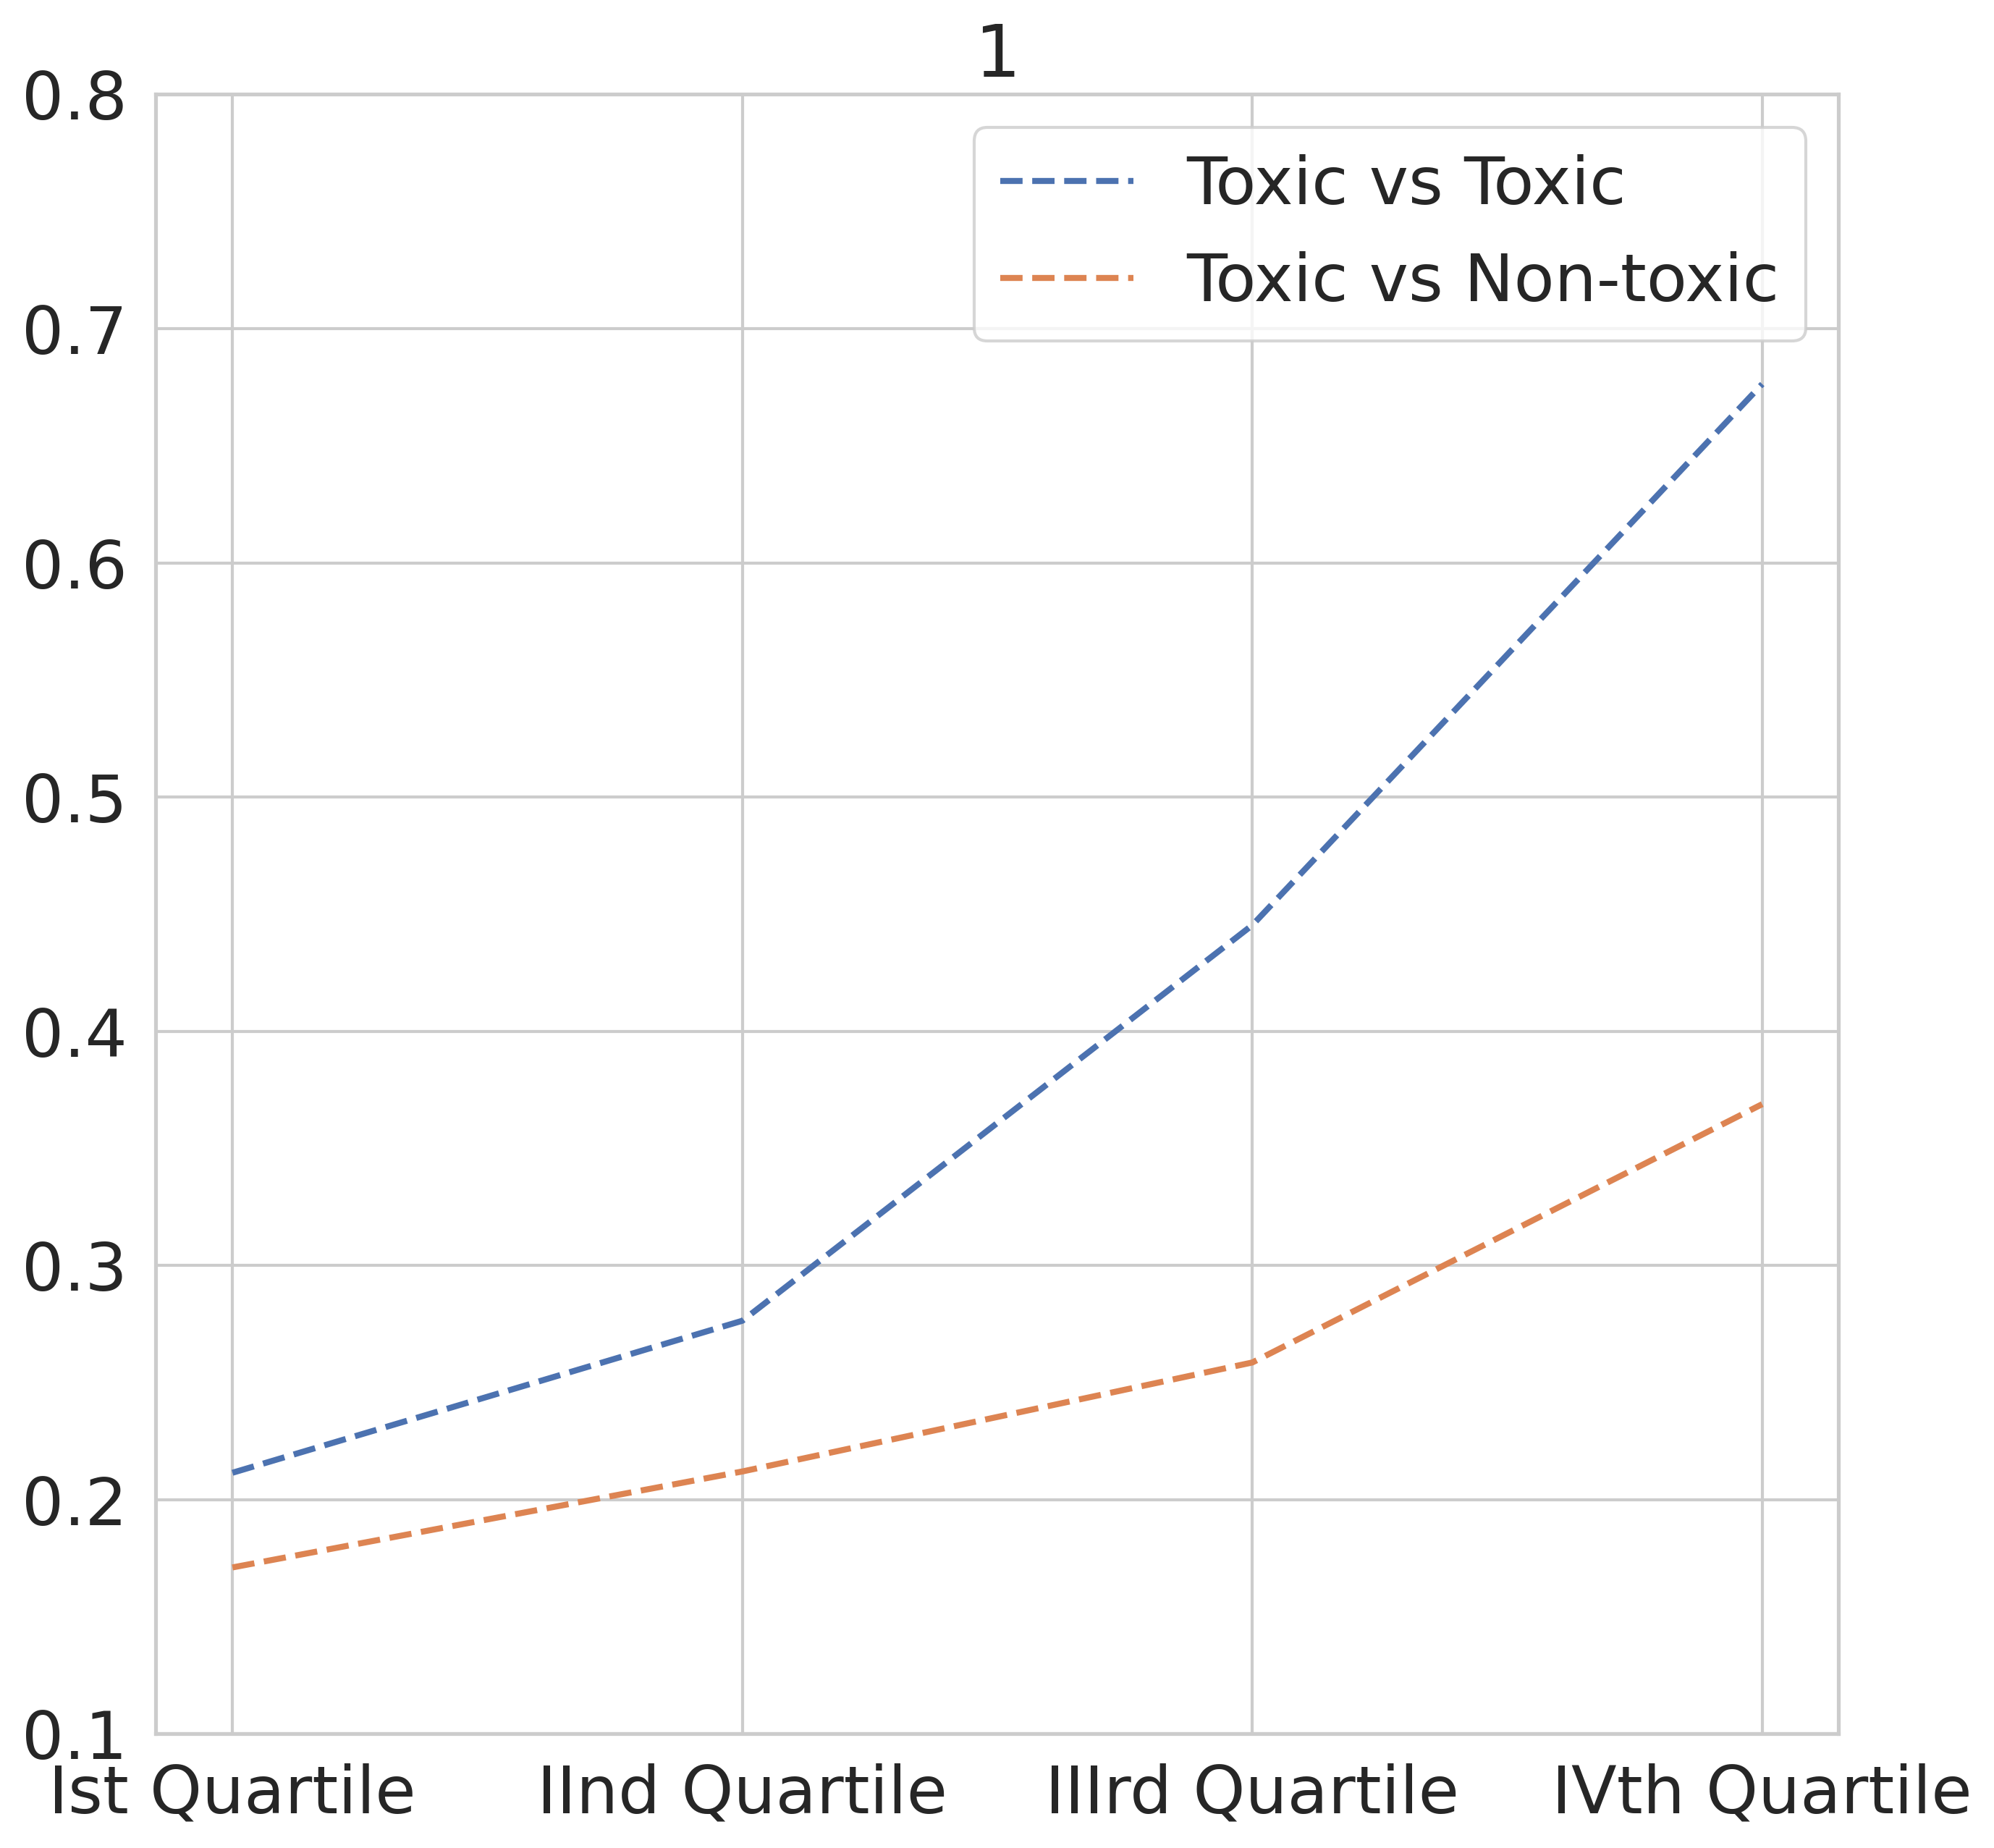

2
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.23787879 0.30683091 0.46357759]
mean for each group and at each moment:
[0.19661218 0.26635312 0.387682   0.56045789]
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.18964041 0.2172361  0.26719446]
mean for each group and at each moment:
[0.16566592 0.19973142 0.24036618 0.32322545]


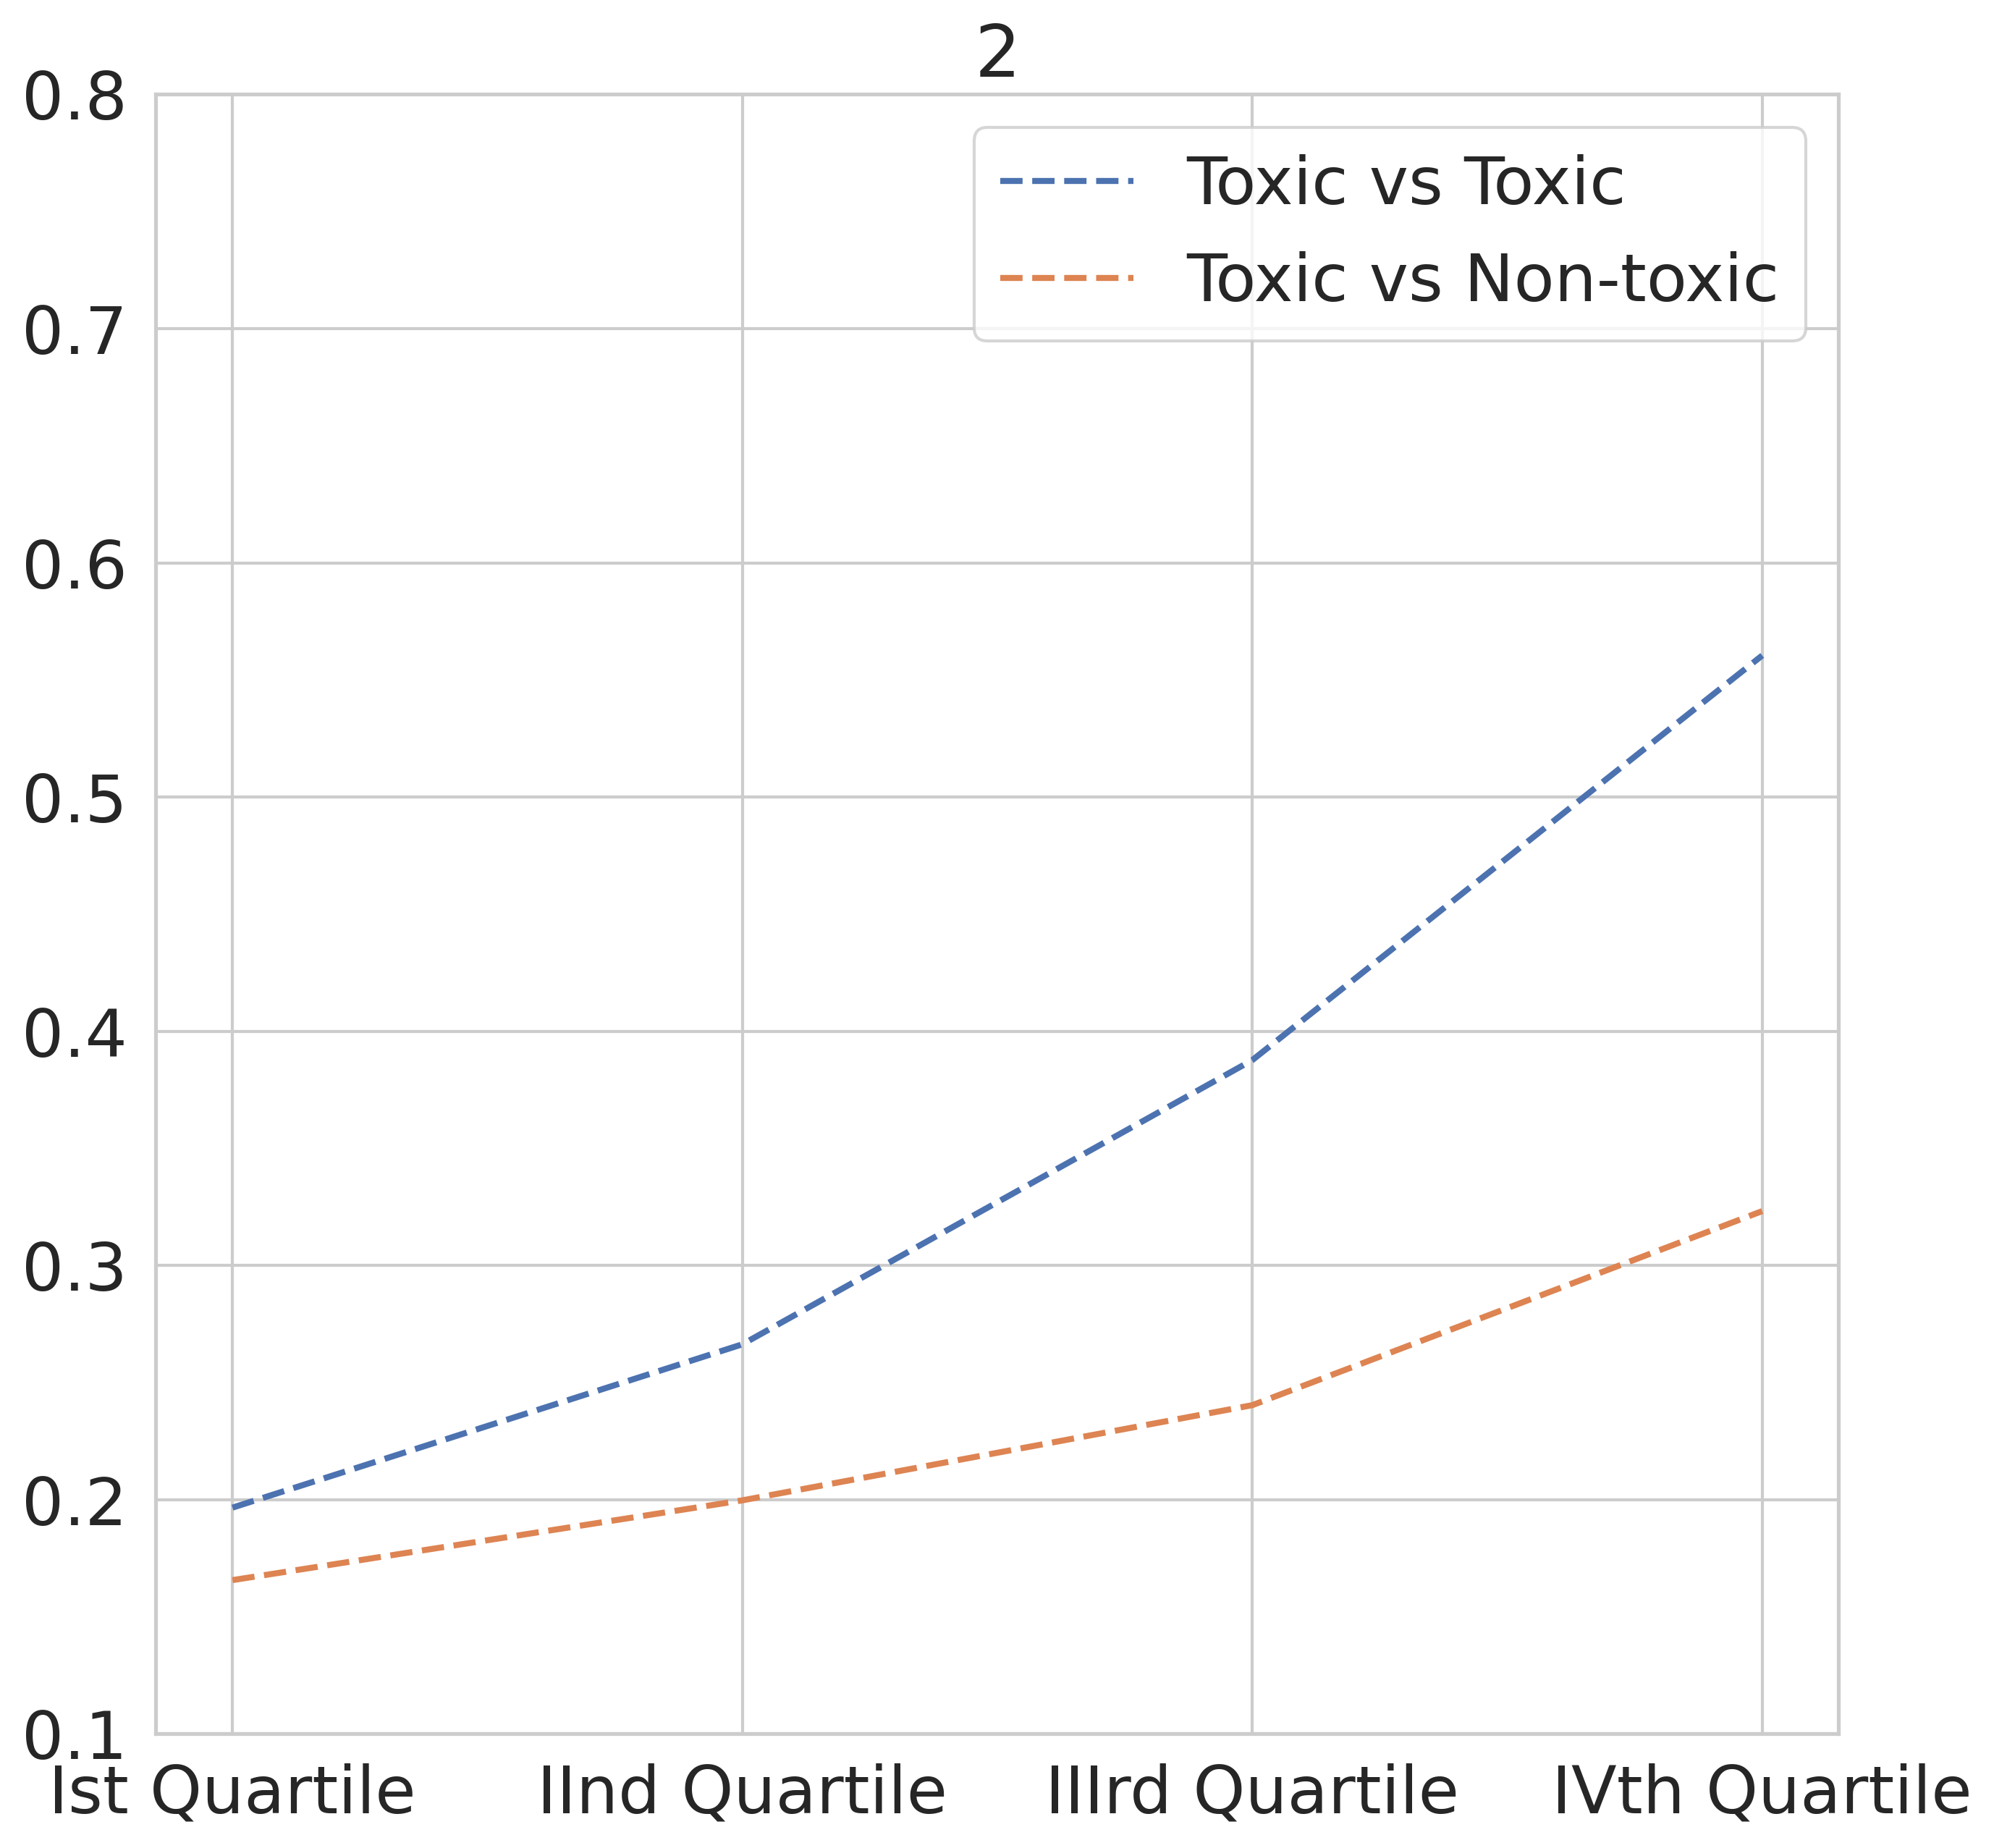

3
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.22222222 0.25925926 0.39393939]
mean for each group and at each moment:
[0.18120246 0.24116501 0.29788883 0.49192746]
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.17142857 0.19565217 0.24528302]
mean for each group and at each moment:
[0.15726012 0.18601535 0.21900354 0.28299617]


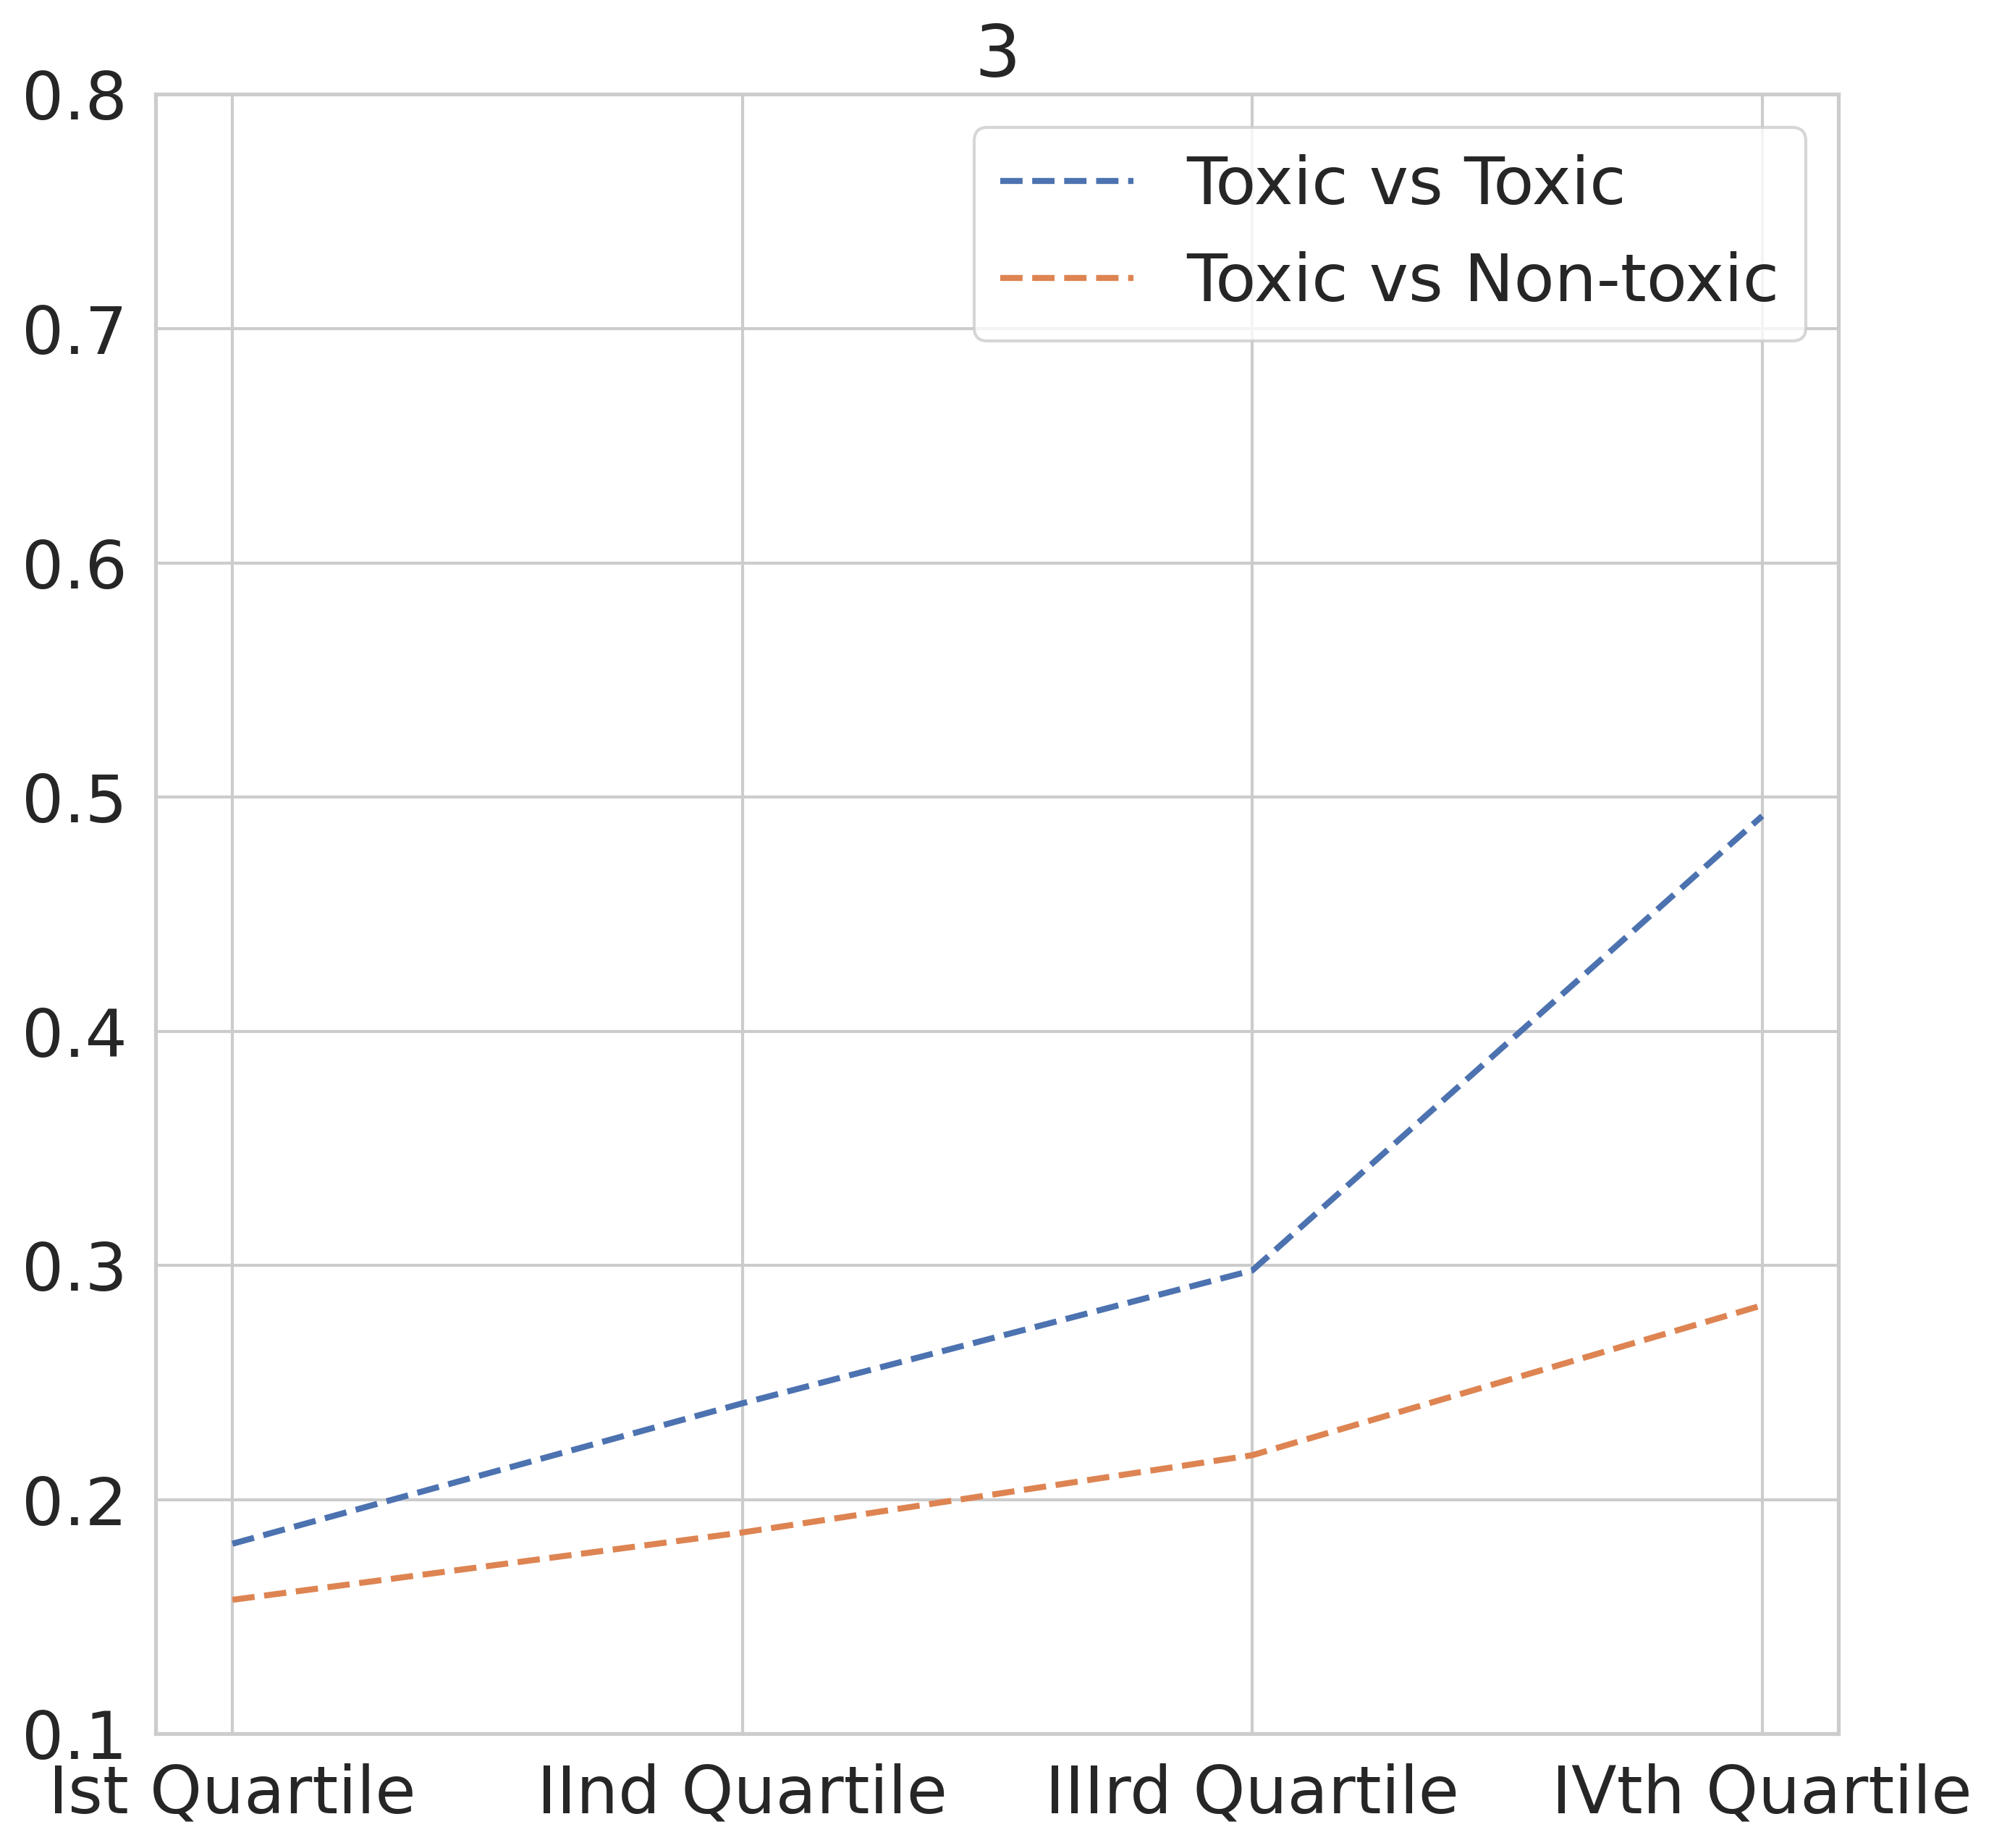

4
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.209375   0.24568966 0.3157967 ]
mean for each group and at each moment:
[0.17470791 0.22791712 0.27374948 0.41383807]
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.16944373 0.18926975 0.2266222 ]
mean for each group and at each moment:
[0.15351249 0.18151622 0.20884094 0.25835857]


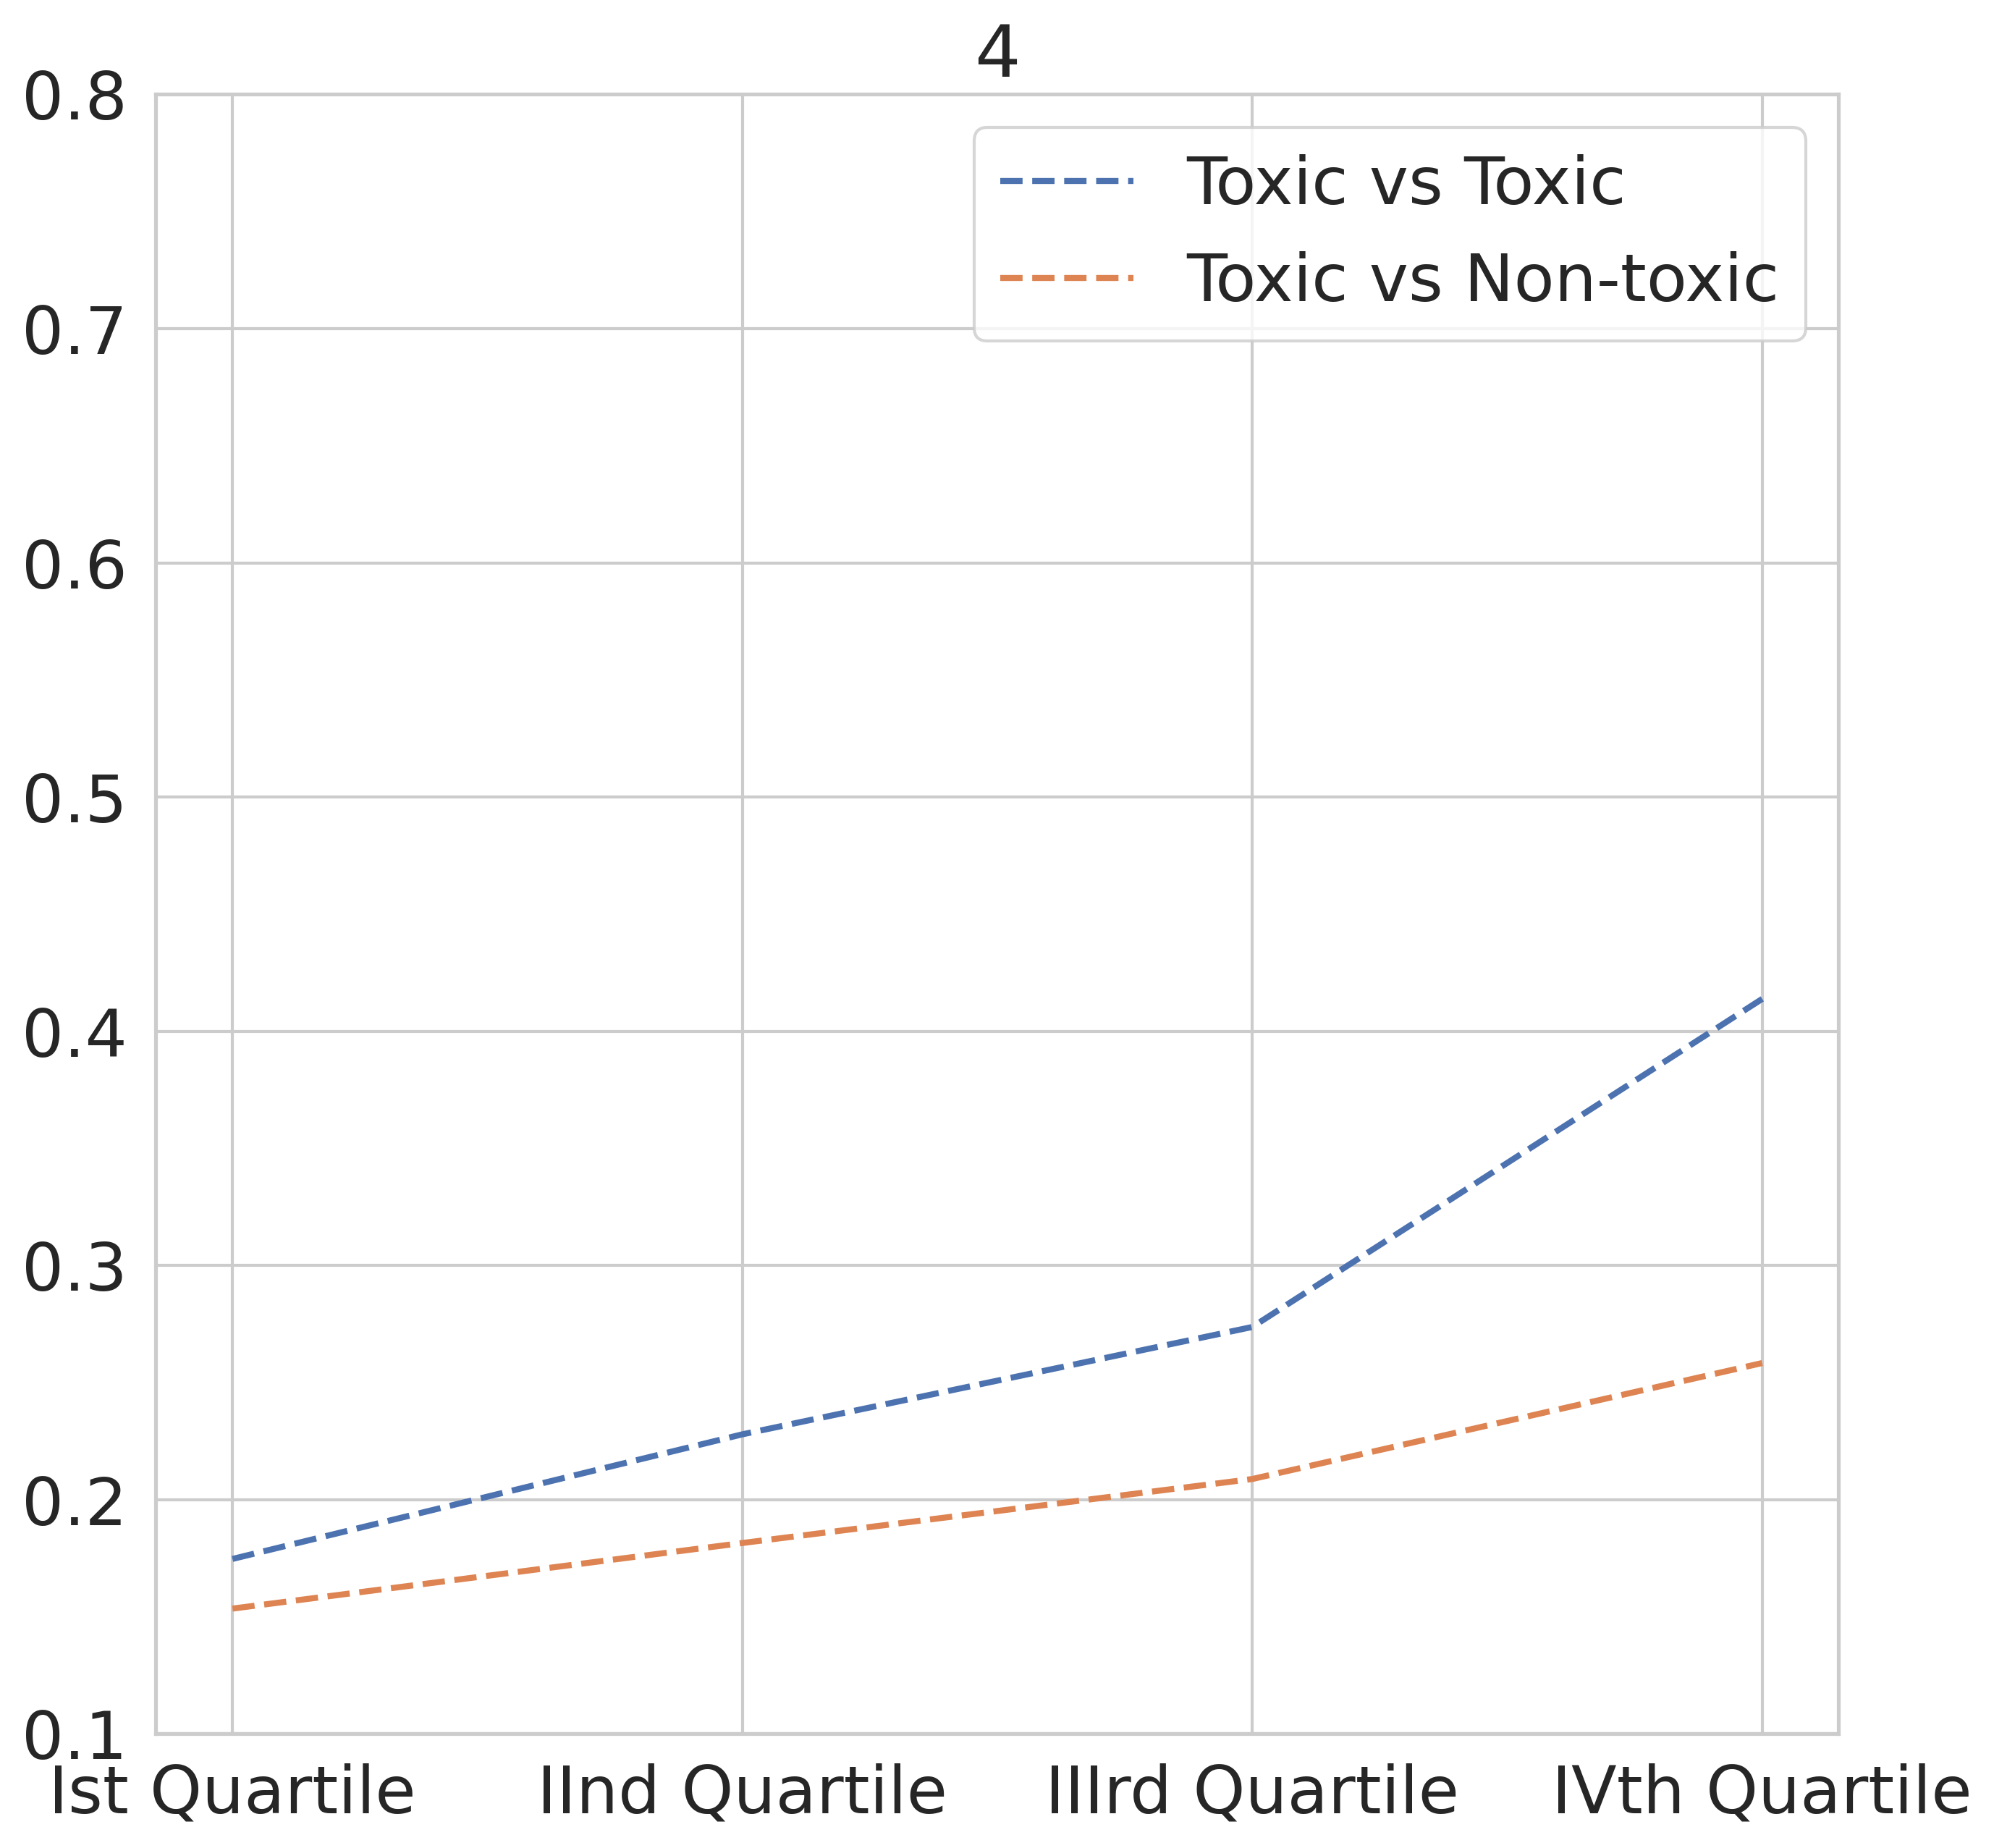

5
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.18604651 0.22222222 0.26865672]
mean for each group and at each moment:
[0.16131469 0.20394212 0.24025623 0.36486464]
quantiles:
 [0.25, 0.5, 0.75]
quantile_values (for each moment):
 [0.16666667 0.18518519 0.20930233]
mean for each group and at each moment:
[0.15031314 0.17684482 0.19632728 0.23542379]


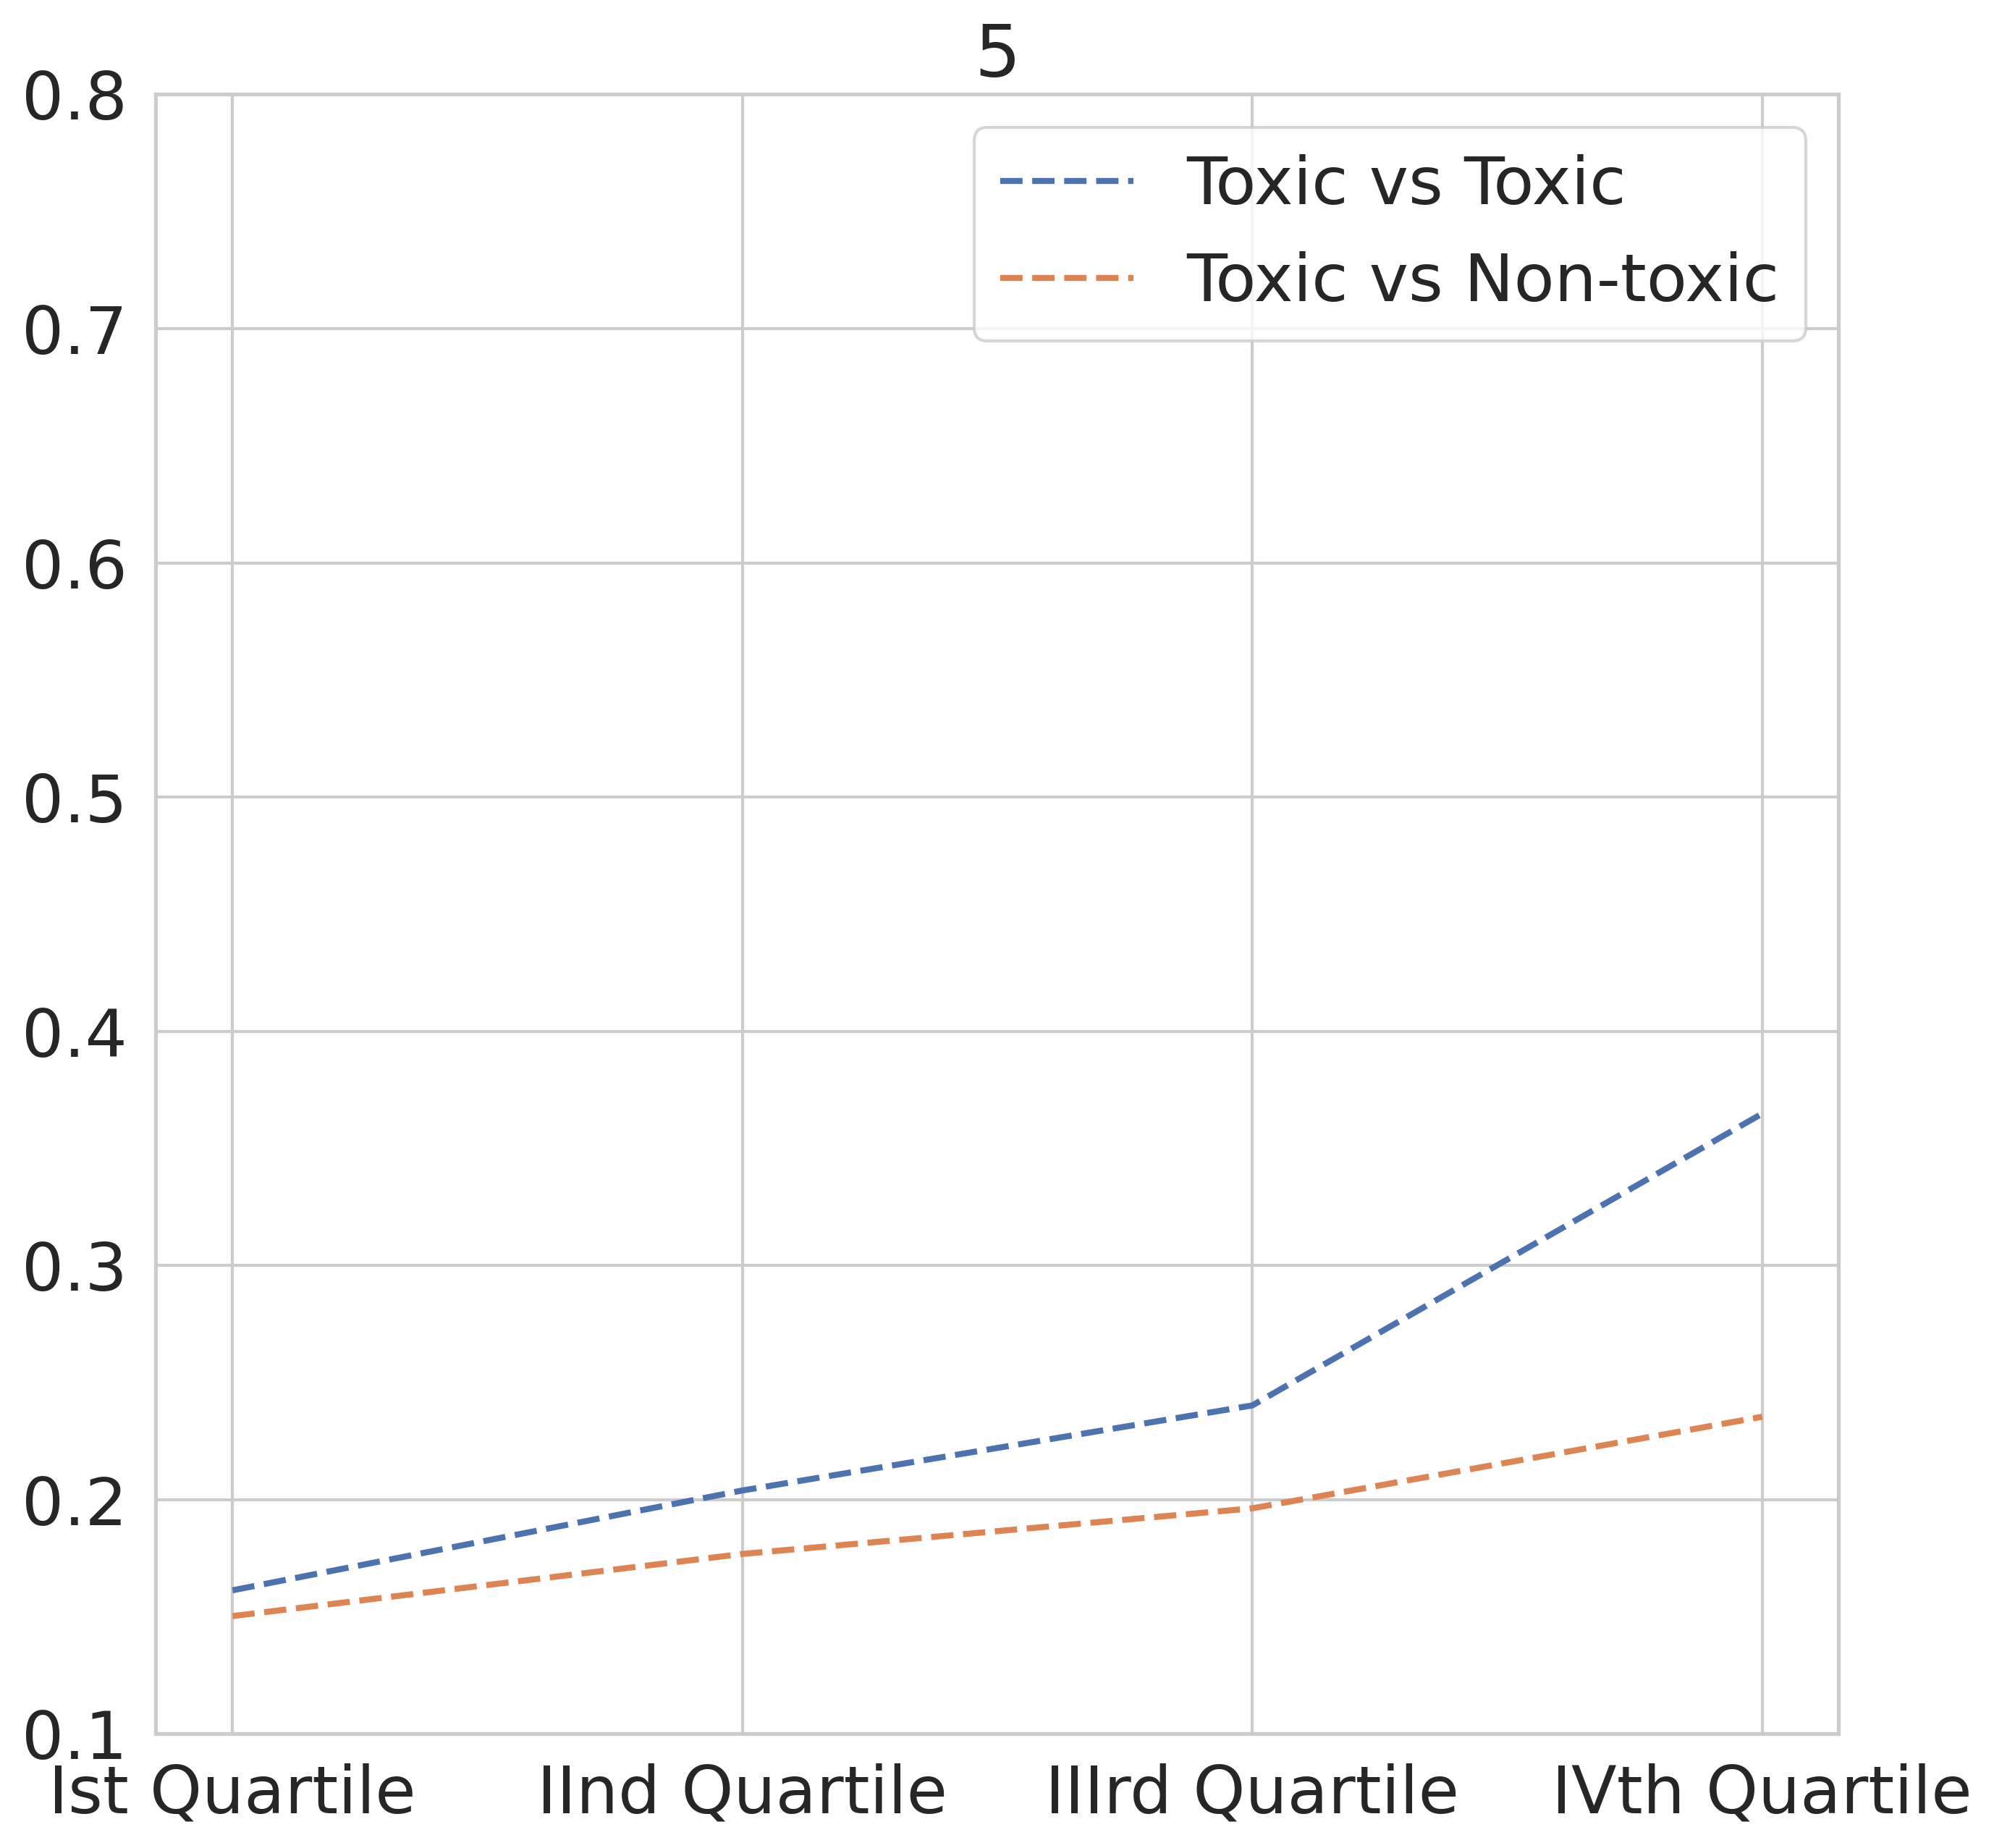

In [30]:
for neighbours in range(1,6):
    print(neighbours)
    df_final_aa_2 = pd.DataFrame()
    df_final_ai_2 = pd.DataFrame()

    for compound in toxic_compounds:

        compounds_wise = pd.DataFrame()
        compounds_wise = df_final_aa[df_final_aa["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:neighbours, :]
        df_final_aa_2 = pd.concat([df_final_aa_2, compounds_wise])

        compounds_wise = pd.DataFrame()
        compounds_wise = df_final_ai[df_final_ai["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:neighbours, :]
        df_final_ai_2 = pd.concat([df_final_ai_2, compounds_wise])


    #df_final_aa_2["CP_Pearson_effect"]=abs(df_final_aa_2["CP_Pearson_effect"])
    df_final_aa_2 = df_final_aa_2.groupby('query').median().sort_values("MFP_Tc").reset_index()

    #df_final_aa_2["CP_Pearson_effect"]=abs(df_final_aa_2["CP_Pearson_effect"])
    df_final_ai_2 = df_final_ai_2.groupby('query').median().sort_values("MFP_Tc").reset_index()
   
    quantile_curves_aa = pd.DataFrame()
    quantile_curves_ai = pd.DataFrame()
    quantile_curves_aa = quantile_curves(np.array(df_final_aa_2["MFP_Tc"]))
    quantile_curves_ai = quantile_curves(np.array(df_final_ai_2["MFP_Tc"]))
    
    Quantile_k_aa = pd.DataFrame(quantile_curves_aa, columns=["Toxic vs Toxic"] , index=['Ist Quartile', 'IInd Quartile', 'IIIrd Quartile','IVth Quartile'])
    Quantile_k_ai =  pd.DataFrame(quantile_curves_ai, columns=["Toxic vs Non-toxic"] , index=['Ist Quartile', 'IInd Quartile', 'IIIrd Quartile','IVth Quartile'])
    
    plt.figure(figsize=(10,10), dpi=300)
    plt.title(neighbours)
    plt.plot( 'Toxic vs Toxic', data=Quantile_k_aa, marker='', linewidth=2, linestyle='dashed', label="Toxic vs Toxic")
    plt.plot( 'Toxic vs Non-toxic', data=Quantile_k_ai, marker='', linewidth=2, linestyle='dashed', label="Toxic vs Non-toxic")
    plt.ylim(0.1, 0.8)
    plt.legend()
    plt.show()

    